In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [2]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False

## 데이터 전처리 불러오기

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Input, Dropout, Conv1DTranspose
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from google.colab import drive

drive.mount('/content/drive')

def get_processed_data():
    base_path = "/content/drive/MyDrive/[AIVLE] 빅 프로젝트 모델링/welding_dataset/"

    vib_normal = pd.read_csv(base_path + "vibration_normal.csv")
    vib_anomaly = pd.read_csv(base_path + "vibration_anomaly.csv")
    cur_normal = pd.read_csv(base_path + "current_normal.csv")
    cur_anomaly = pd.read_csv(base_path + "current_anomaly.csv")

    # 데이터셋 분리
    vib_train_dataset = vib_normal.iloc[:1758, 1:].values
    vib_test_dataset = pd.concat(
        [vib_normal.iloc[1758:, 1:], vib_anomaly.iloc[:, 1:]], ignore_index=True
    ).values

    cur_train_dataset = cur_normal.iloc[:8170, 1:].values
    cur_test_dataset = pd.concat(
        [cur_normal.iloc[8170:, 1:], cur_anomaly.iloc[:, 1:]], ignore_index=True
    ).values

    # 진동용 스케일러
    scaler_vib = StandardScaler()
    vib_train_dataset = scaler_vib.fit_transform(vib_train_dataset)
    vib_test_dataset = scaler_vib.transform(vib_test_dataset)

    # 전류용 스케일러
    scaler_cur = StandardScaler()
    cur_train_dataset = scaler_cur.fit_transform(cur_train_dataset)
    cur_test_dataset = scaler_cur.transform(cur_test_dataset)

    vib_train_dataset = vib_train_dataset.reshape(
        vib_train_dataset.shape[0], vib_train_dataset.shape[1], 1
    )
    vib_test_dataset = vib_test_dataset.reshape(
        vib_test_dataset.shape[0], vib_test_dataset.shape[1], 1
    )
    cur_train_dataset = cur_train_dataset.reshape(
        cur_train_dataset.shape[0], cur_train_dataset.shape[1], 1
    )
    cur_test_dataset = cur_test_dataset.reshape(
        cur_test_dataset.shape[0], cur_test_dataset.shape[1], 1
    )

    return (
        scaler_vib,
        scaler_cur,
        vib_train_dataset,
        vib_test_dataset,
        cur_train_dataset,
        cur_test_dataset,
    )

scaler_vib, scaler_cur, vib_train_dataset, vib_test_dataset, cur_train_dataset, cur_test_dataset = get_processed_data()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#AI 모델 구축

## 모델 설계

In [4]:
def Conv_AE(input_data):
  model = Sequential()
  model.add(Input(shape=(input_data.shape[1],	input_data.shape[2])))
  model.add(Conv1D(filters=64,	kernel_size=input_data.shape[1]	//64,	padding='same',	strides=2,	activation='relu'))
  model.add(Conv1D(filters=32,	kernel_size=input_data.shape[1]	//64,	padding='same',	activation='relu'))
  model.add(Conv1DTranspose(filters=64,	kernel_size=input_data.shape[1]	//64,	padding='same',	strides=2, activation='relu'))
  model.add(Conv1DTranspose(filters=1,	kernel_size=input_data.shape[1]	//64,	padding='same'))
  return model

### 진동 모델 설계

In [5]:
vib_model = Conv_AE(vib_train_dataset)
vib_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 256, 64)        │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 256, 32)        │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose                │ (None, 512, 64)        │        16,448 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_1              │ (None, 512, 1)         │           513 │
│ (Conv1DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,953 (132.63 KB)

 Trainable params: 33,953 (132.63 KB)

 Non-trainable params: 0 (0.00 B)

### 전류 모델 설계

In [6]:
cur_model	=	Conv_AE(cur_train_dataset)
cur_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 512, 64)        │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 512, 32)        │        32,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_2              │ (None, 1024, 64)       │        32,832 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_3              │ (None, 1024, 1)        │         1,025 │
│ (Conv1DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,745 (264.63 KB)

 Trainable params: 67,745 (264.63 KB)

 Non-trainable params: 0 (0.00 B)

## 모델 학습

### 진동 모델 학습

In [7]:
es = EarlyStopping(monitor='val_loss', patience=10)

vib_model.compile(loss='mae', optimizer='adam')
vib_history = vib_model.fit(x=vib_train_dataset, y=vib_train_dataset, epochs=100, validation_split=0.2, callbacks=[es])

Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.4442 - val_loss: 0.0821
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0592 - val_loss: 0.0446
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0582 - val_loss: 0.0384
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0351 - val_loss: 0.0412
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0322 - val_loss: 0.0297
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0308 - val_loss: 0.0421
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0335 - val_loss: 0.0267
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0249 - val_loss: 0.0385
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0291 - val_loss: 0.0293
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0265 - val_loss: 0.0440
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0302 - val_loss: 0.0262
Epoch 12/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.

### 전류 모델 학습

In [8]:
es = EarlyStopping(monitor='val_loss', patience=10)

cur_model.compile(loss='mae', optimizer='adam')
cur_history = cur_model.fit(x=cur_train_dataset, y=cur_train_dataset, epochs=100, validation_split=0.2, callbacks=[es])

Epoch 1/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.1480 - val_loss: 0.0962
Epoch 2/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0475 - val_loss: 0.0512
Epoch 3/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0268 - val_loss: 0.0325
Epoch 4/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0261 - val_loss: 0.0185
Epoch 5/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0228 - val_loss: 0.0961
Epoch 6/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0303 - val_loss: 0.0429
Epoch 7/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0551 - val_loss: 0.0125
Epoch 8/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0232 - val_loss: 0.0110
Epoch 9/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0166 - val_loss: 0.0153
Epoch 10/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0185 - val_loss: 0.0228
Epoch 11/100
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0167 - val_loss: 0.0162
Epoch 12/100
205/205 ━━━━━━━━━━━━━━━━━━

#### 학습 결과

In [9]:
vib_history.history['loss']

[0.2762925326824188,
 0.05103984475135803,
 0.05744878202676773,
 0.03416213393211365,
 0.030913149937987328,
 0.031627342104911804,
 0.03202447667717934,
 0.026638280600309372,
 0.026851672679185867,
 0.027711955830454826,
 0.027093179523944855,
 0.03414411097764969,
 0.029538461938500404,
 0.024569328874349594,
 0.033868834376335144,
 0.023505806922912598,
 0.02287091501057148,
 0.02302633970975876,
 0.03518492355942726,
 0.021003015339374542,
 0.022140197455883026,
 0.0243484266102314,
 0.03171105682849884,
 0.023694325238466263,
 0.01779308170080185,
 0.020480914041399956,
 0.02885613590478897,
 0.021224655210971832,
 0.01621449738740921,
 0.026980727910995483,
 0.02058476395905018,
 0.022314533591270447,
 0.025994274765253067,
 0.018639463931322098,
 0.02016277052462101,
 0.024825412780046463,
 0.025794068351387978,
 0.016039706766605377,
 0.0239748302847147,
 0.02188447304069996,
 0.025316564366221428]

In [10]:
vib_history.history['val_loss']

[0.08207730948925018,
 0.04464367777109146,
 0.038447681814432144,
 0.04124612361192703,
 0.029688475653529167,
 0.042136404663324356,
 0.026684902608394623,
 0.03845652937889099,
 0.029307324439287186,
 0.043957579880952835,
 0.026156969368457794,
 0.04183647036552429,
 0.02785031870007515,
 0.021980728954076767,
 0.027230216190218925,
 0.020615117624402046,
 0.018656373023986816,
 0.053985122591257095,
 0.027256017550826073,
 0.019964994862675667,
 0.018743854016065598,
 0.0681954026222229,
 0.03398540988564491,
 0.019804688170552254,
 0.024537475779652596,
 0.031060487031936646,
 0.01740686409175396,
 0.02079911157488823,
 0.02073211595416069,
 0.025334788486361504,
 0.015207401476800442,
 0.03385293856263161,
 0.018241461366415024,
 0.016391463577747345,
 0.030369330197572708,
 0.022088345140218735,
 0.017629705369472504,
 0.018077991902828217,
 0.0171467624604702,
 0.019024470821022987,
 0.027926834300160408]

In [11]:
cur_history.history['loss']

[0.08141057193279266,
 0.03781811147928238,
 0.02953953482210636,
 0.021767761558294296,
 0.030630791559815407,
 0.02219250053167343,
 0.031880177557468414,
 0.021967191249132156,
 0.018153240904211998,
 0.017587222158908844,
 0.018915751948952675,
 0.016989734023809433,
 0.014631248079240322,
 0.016299447044730186,
 0.016481658443808556,
 0.020230639725923538,
 0.014102510176599026,
 0.014161914587020874]

In [12]:
cur_history.history['val_loss']

[0.09620876610279083,
 0.051180265843868256,
 0.032471559941768646,
 0.018492013216018677,
 0.09607251733541489,
 0.04293014854192734,
 0.01252245344221592,
 0.011044276878237724,
 0.015309310518205166,
 0.022763751447200775,
 0.01615523174405098,
 0.01623067818582058,
 0.01557170506566763,
 0.03316572308540344,
 0.01480655837804079,
 0.012568630278110504,
 0.039228156208992004,
 0.03379382938146591]

진동 데이터 학습 결과

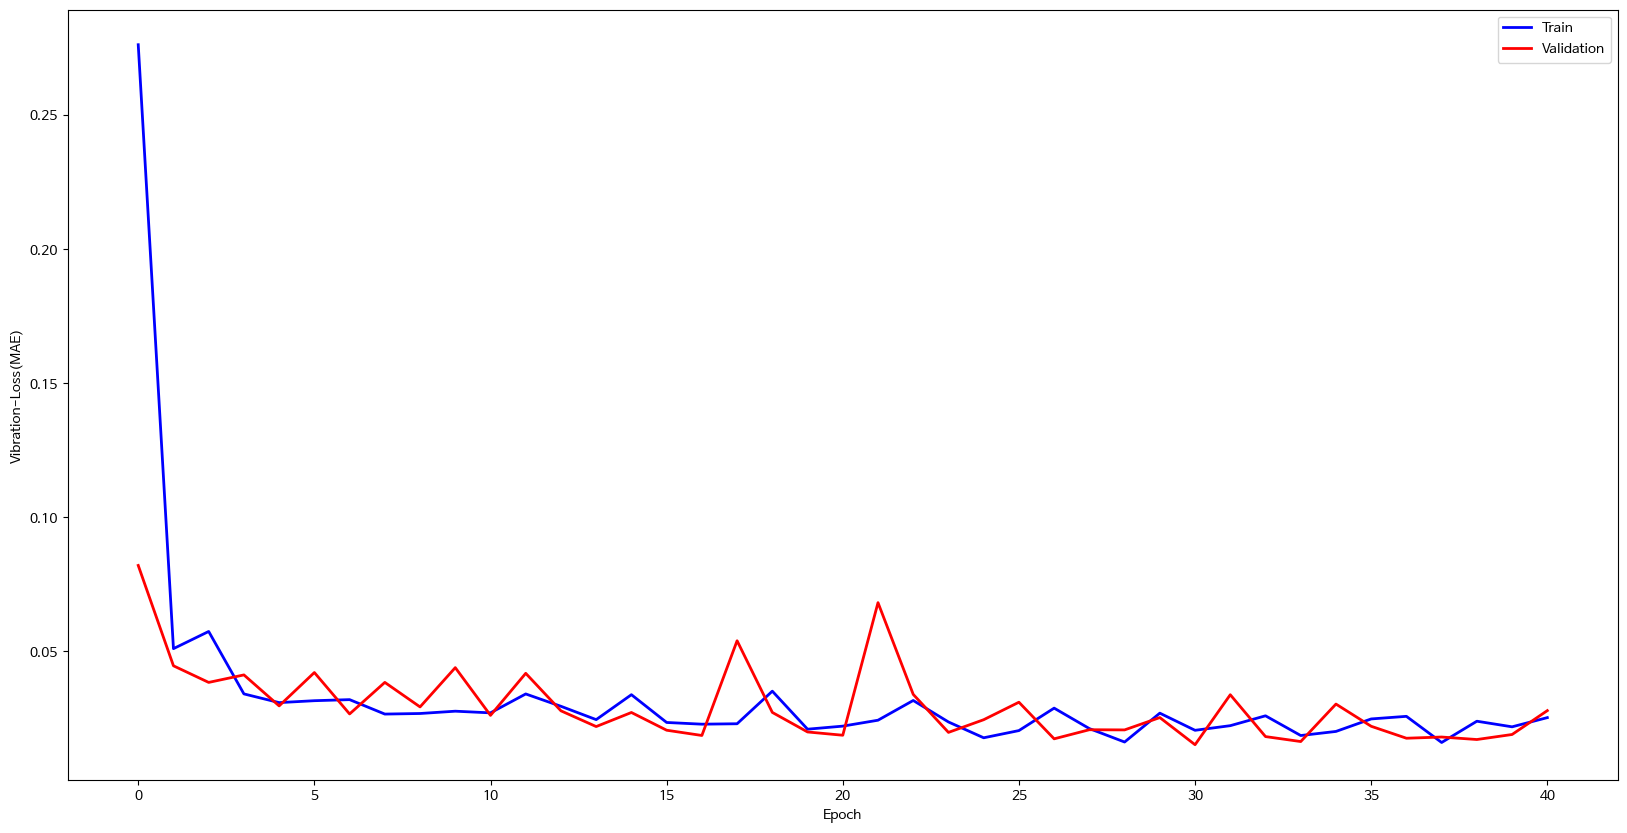

In [ ]:
plt.figure(figsize=(20,	10))
plt.plot(vib_history.history['loss'],	color='blue',	label='Train',	linewidth=2)
plt.plot(vib_history.history['val_loss'],	color='red',	label='Validation',	linewidth=2)
plt.ylabel('Vibration-Loss(MAE)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

전류 데이터 학습 결과

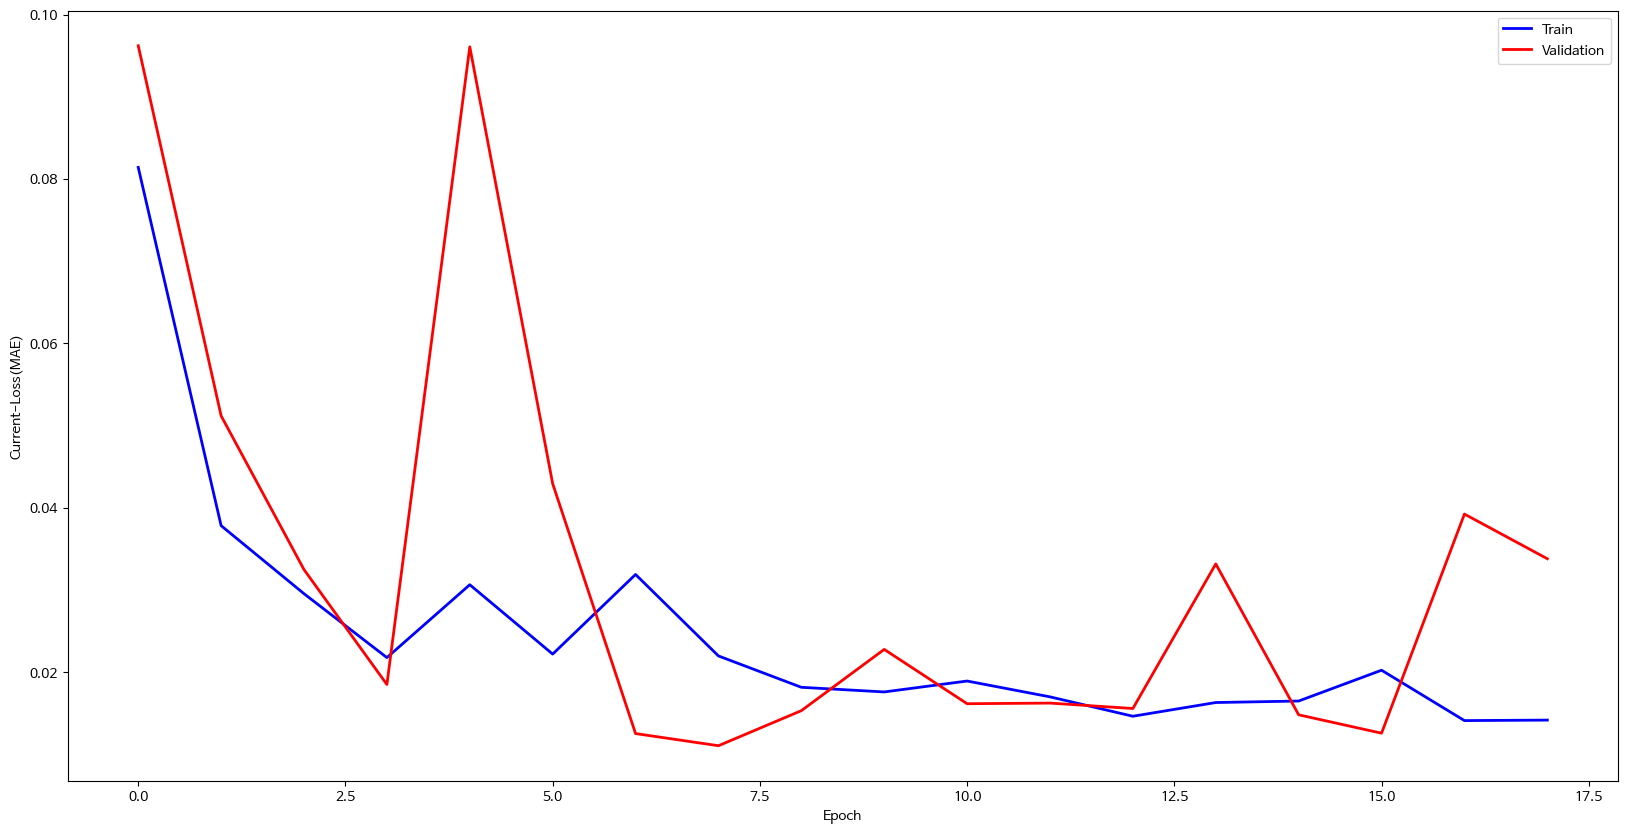

In [14]:
plt.figure(figsize=(20,	10))
plt.plot(cur_history.history['loss'],	color='blue',	label='Train',	linewidth=2)
plt.plot(cur_history.history['val_loss'],	color='red',	label='Validation',	linewidth=2)
plt.ylabel('Current-Loss(MAE)')
plt.xlabel('Epoch')
plt.legend()
plt.show()

#### 학습 결과 분석 : 예측 결과 확인

In [15]:
vib_predict = vib_model.predict(vib_train_dataset)
vib_predict.shape

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


(1758, 512, 1)

In [16]:
cur_predict = cur_model.predict(cur_train_dataset)
cur_predict.shape

256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


(8170, 1024, 1)

#### 진동) 원본 데이터와 예측 데이터 비교

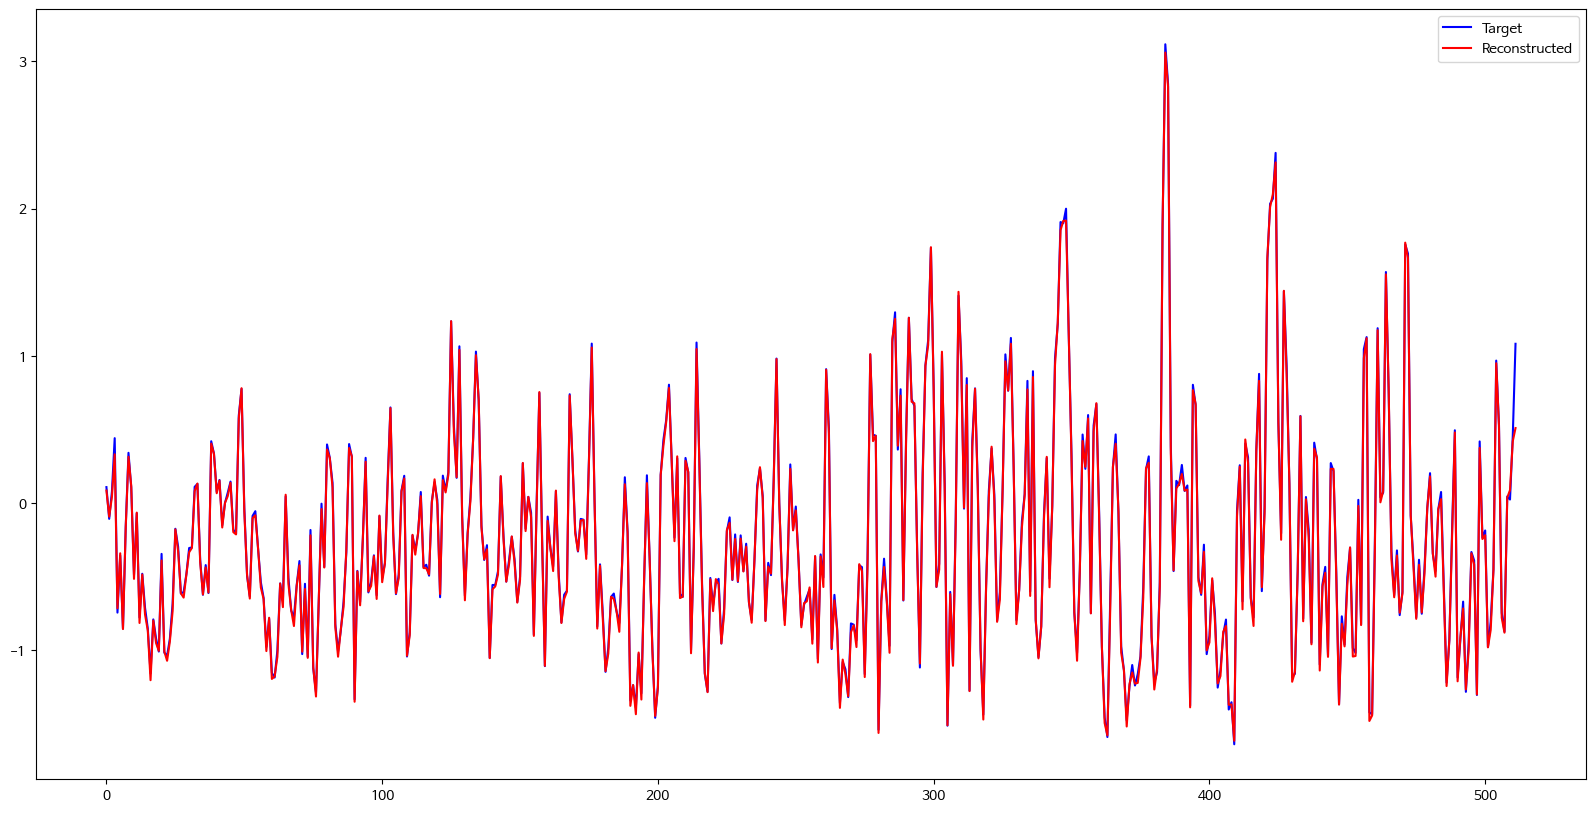

In [ ]:
plt.figure(figsize=(20,	10))
plt.plot(vib_train_dataset[0],	color='blue',	label='Target')
plt.plot(vib_predict[0],	color='red',	label='Reconstructed')
plt.legend()
plt.show()

#### 전류) 원본 데이터와 예측 데이터 비교

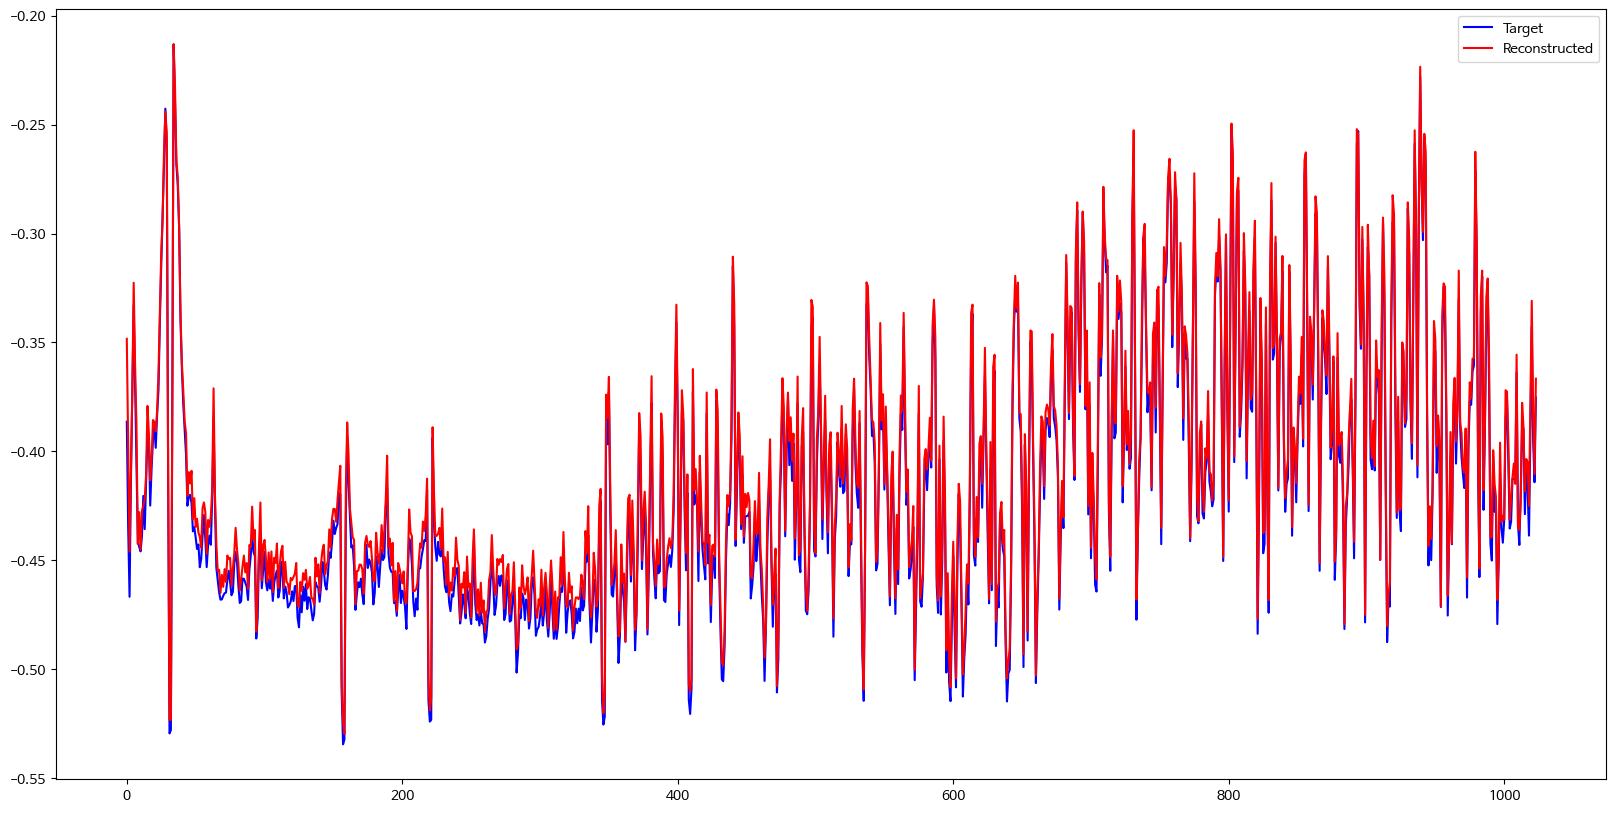

In [18]:
plt.figure(figsize=(20,	10))
plt.plot(cur_train_dataset[0],	color='blue',	label='Target')
plt.plot(cur_predict[0],	color='red', label='Reconstructed')
plt.legend()
plt.show()

## 임계치 설정


### 복원 오차 확인 : Reconstruction Error
- 복원 오차를 쓰는 이유
 -  지금 현재 AutoEncoder 기반 모델은 이상을 감지할때, 현재 학습한 모델의 정상 데이터의 패턴을 기억하고 있음
  - 따라서, 새로운 데이터가 들어오면 모델은 같은 데이터를 인코딩(압축)하고 디코딩하여 복원함 -> 이때 복원한 값이 입력했던 값이랑 차이가 크면, 이상으로 간주함
  - 왜 차이가 날까? 모델은 정상 패턴만 학습했기에 이상한 입력치에 익숙치 않음

In [19]:
vib_mae	=	np.mean(np.abs(vib_predict - vib_train_dataset),	axis=1)
vib_mae

array([[0.02290396],
       [0.02272596],
       [0.0236824 ],
       ...,
       [0.0286419 ],
       [0.02807366],
       [0.02697038]])

In [20]:
cur_mae	=	np.mean(np.abs(cur_predict - cur_train_dataset),	axis=1)
cur_mae

array([[0.00706706],
       [0.00713354],
       [0.00688047],
       ...,
       [0.00694009],
       [0.00700908],
       [0.00712554]])

### 임계치 설정

진동, 전류 학습 데이터셋 분포 확인

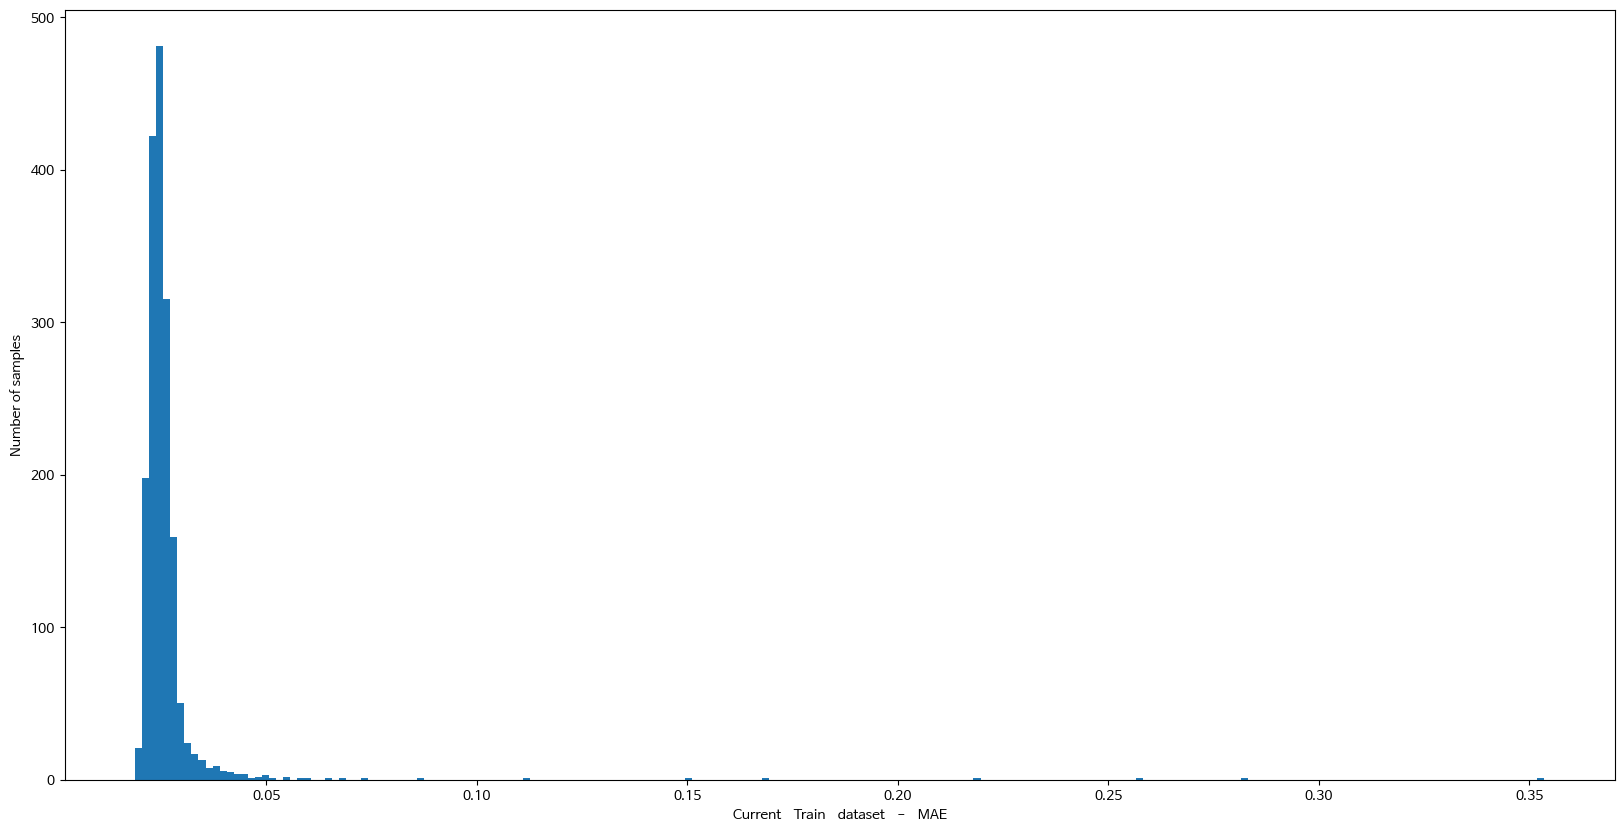

In [21]:
plt.figure(figsize=(20,	10))
plt.hist(x=vib_mae,	bins=200)
plt.xlabel('Current	Train	dataset	-	MAE')
plt.ylabel('Number of samples')
plt.show()

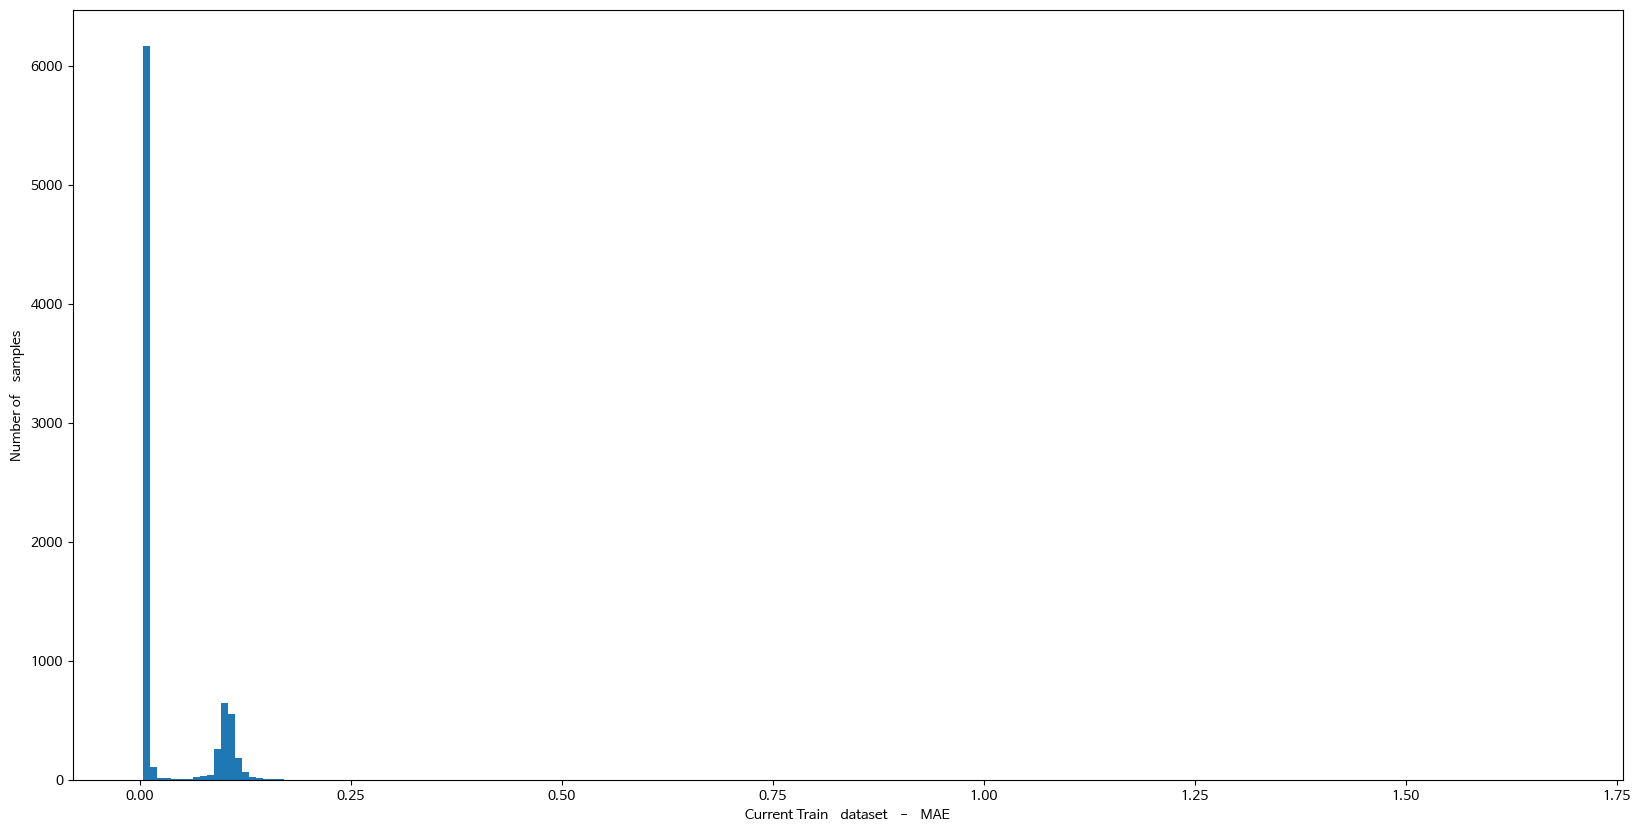

In [22]:
plt.figure(figsize=(20,	10))
plt.hist(x=cur_mae,	bins=200)
plt.xlabel('Current Train	dataset	-	MAE')
plt.ylabel('Number of	samples')
plt.show()

임계치 설정 : 3시그마 규칙으로 임계치 결정하기
- 3시그마 규칙 ? 평균에서 3 표준편차 범위

In [ ]:
vib_threshold	=	np.mean(vib_mae)	+	3	*	np.std(vib_mae)
cur_threshold	=	np.mean(cur_mae)	+	3	*	np.std(cur_mae)
print('진동 데이터 임계치:',	vib_threshold)
print('전류 데이터 임계치:',	cur_threshold)

진동 데이터 임계치: 0.06819714175465803
전류 데이터 임계치: 0.17035013197994323


학습에 사용된 데이터의 복원오차와 임계치 시각화
- 대부분의 데이터가 임계치 보다 낮음을 확인할 수 있음

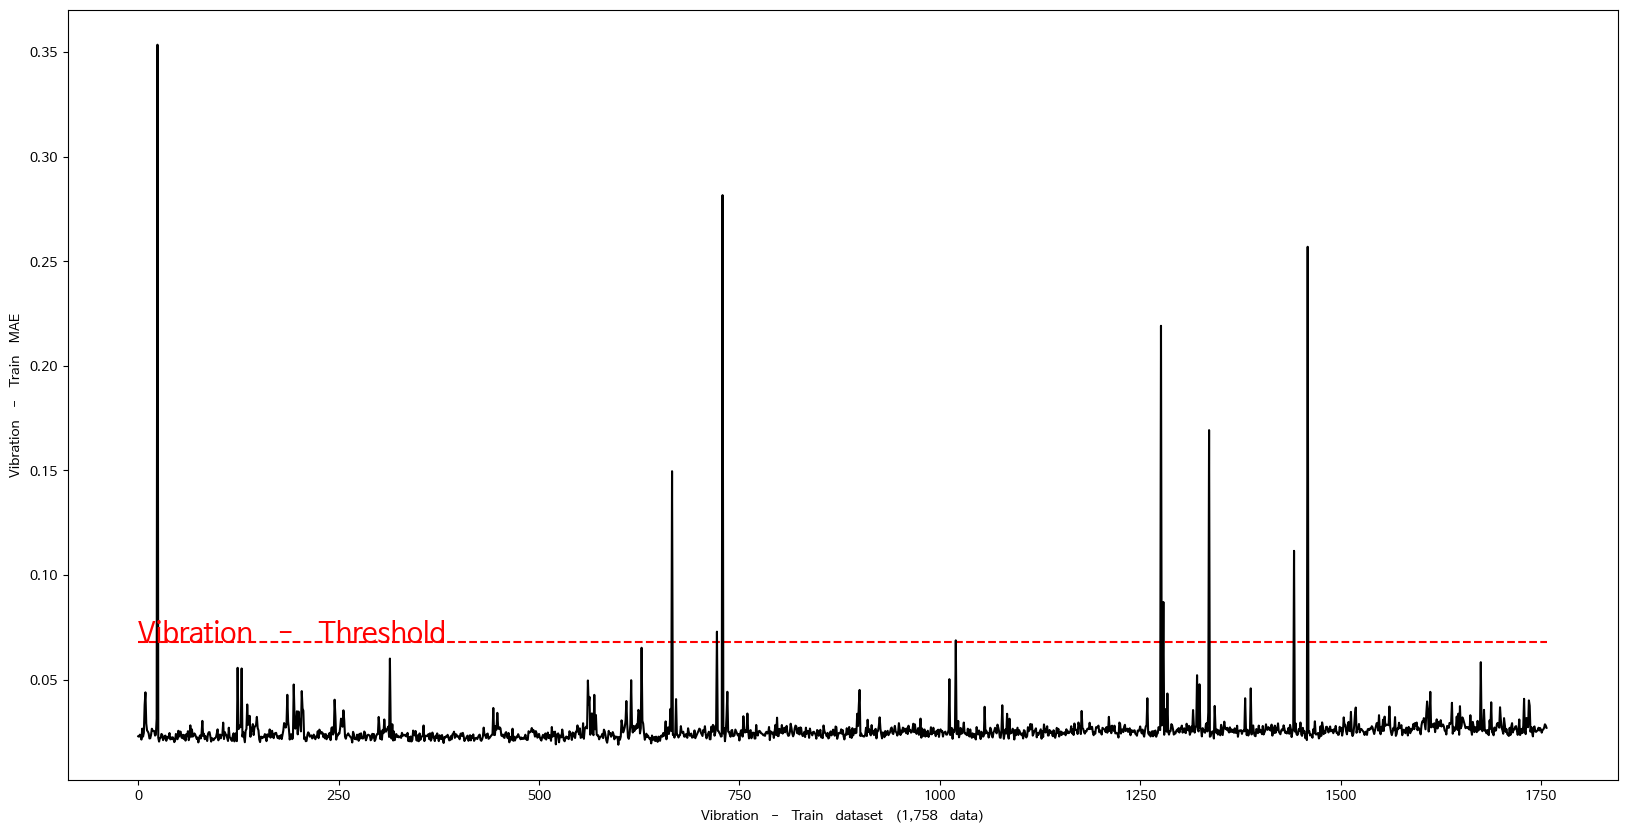

In [24]:
plt.figure(figsize=(20,	10))
plt.text(x=0,	y=vib_threshold,	s='Vibration	-	Threshold',	fontsize=20,	color='red')
plt.hlines(y=vib_threshold,	xmin=0,	xmax=len(vib_mae),	color='red',	linestyle='--')
plt.xlabel('Vibration	-	Train	dataset	(1,758	data)')
plt.ylabel('Vibration	-	Train	MAE')
plt.plot(vib_mae,	color='black')
plt.show()

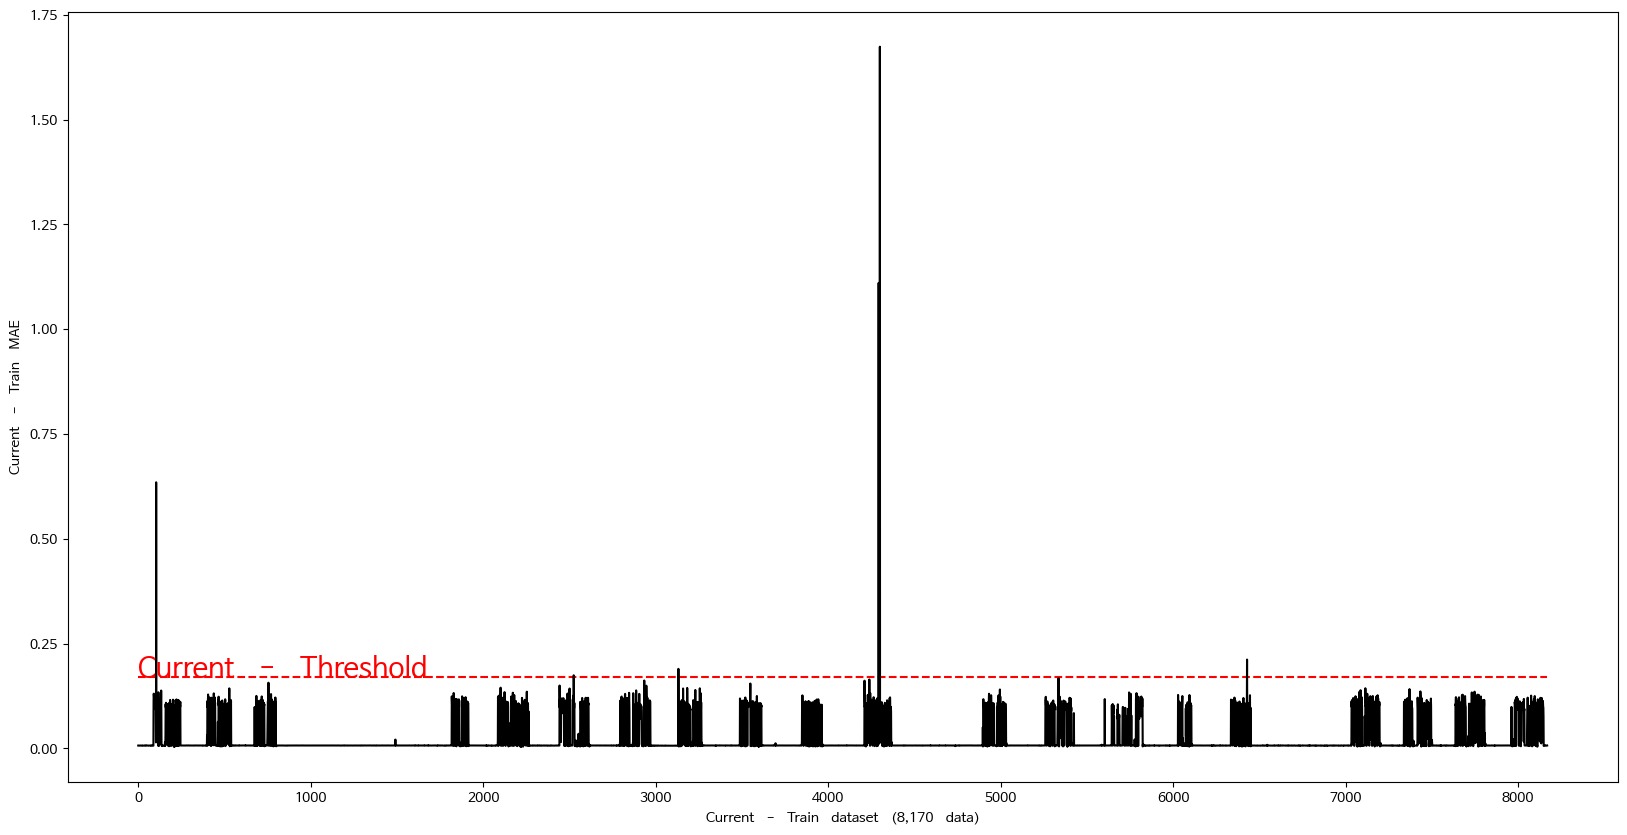

In [ ]:
plt.figure(figsize=(20,	10))
plt.text(x=0,	y=cur_threshold,	s='Current	-	Threshold',	fontsize=20,	color='red')
plt.hlines(y=cur_threshold,	xmin=0,	xmax=len(cur_mae),	color='red',	linestyle='--')
plt.xlabel('Current	-	Train	dataset	(8,170	data)')
plt.ylabel('Current	-	Train	MAE')
plt.plot(cur_mae,	color='black')
plt.show()

## AI 모델 평가
: 진동 학습 데이터셋, 전류 학습 데이터셋, 모델, 임계치로 테스트 데이터셋의 정상/이상 여부를 판별할 수 있음

#### 테스트 데이터셋의 복원 오차 구하기

In [ ]:
vib_predict_test = vib_model.predict(vib_test_dataset)
vib_mae_test = np.mean(np.abs(vib_predict_test - vib_test_dataset),	axis=1)
vib_mae_test.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


(32, 1)

In [ ]:
cur_predict_test =	cur_model.predict(cur_test_dataset)
cur_mae_test = np.mean(np.abs(cur_predict_test - cur_test_dataset),	axis=1)
cur_mae_test.shape

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


(64, 1)

#### 진동 테스트 데이터셋 (32개)의 복원 오차 및 임계치 시각화

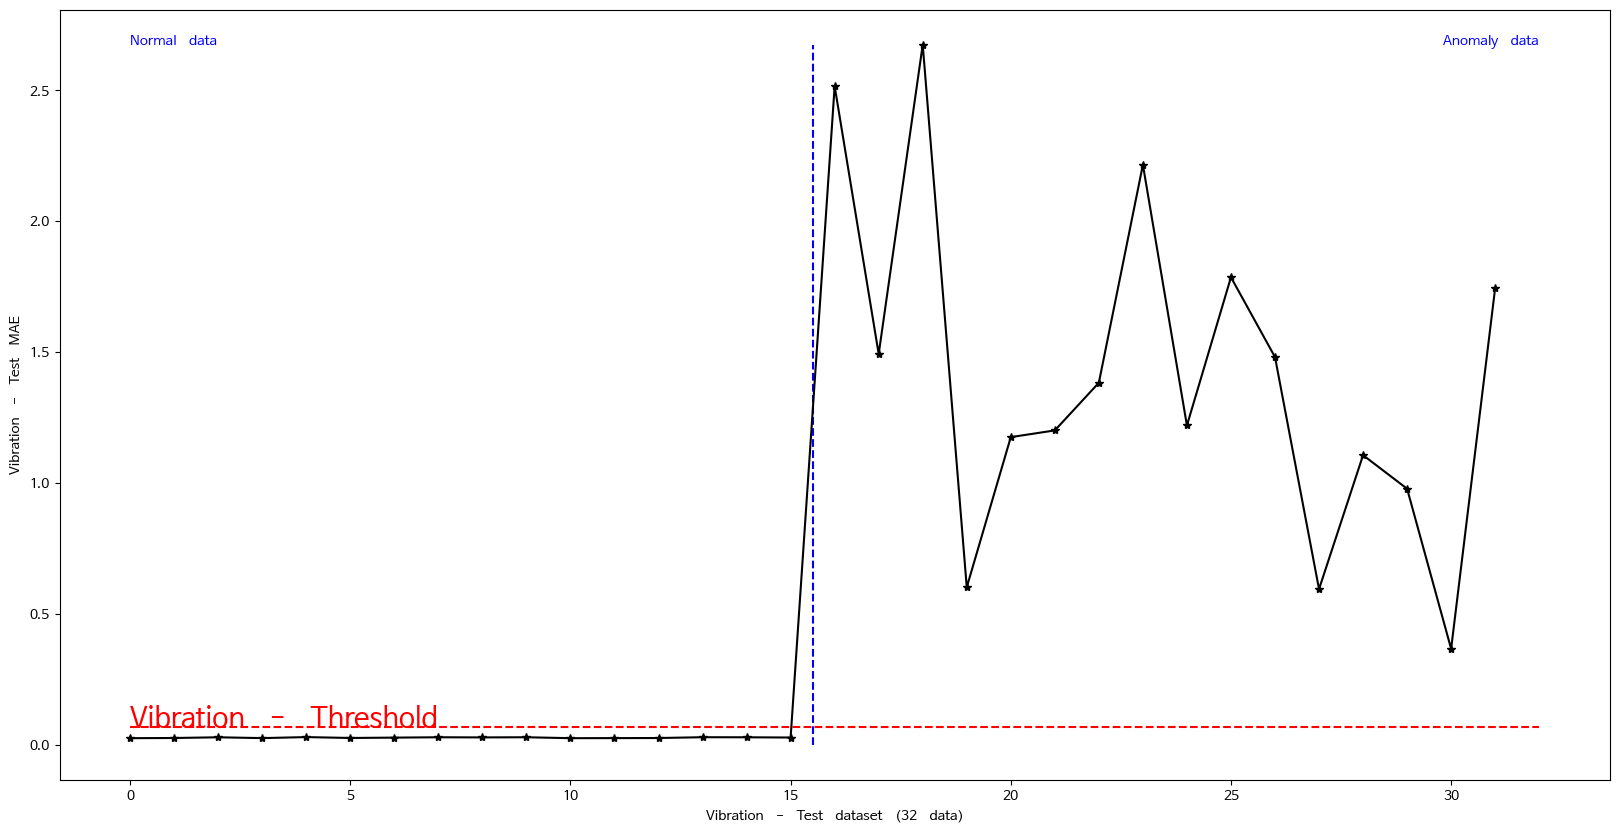

In [ ]:
plt.figure(figsize=(20,	10))
plt.text(x=0, y=max(vib_mae_test), s='Normal data',	horizontalalignment='left',	color='blue')
plt.text(x=32, y=max(vib_mae_test), s='Anomaly data', horizontalalignment='right', color='blue')
plt.vlines(x=15.5,	ymin=0,	ymax=max(vib_mae_test),	color='blue', linestyle='--')
plt.text(x=0, y=vib_threshold, s='Vibration	- Threshold',	fontsize=20, color='red')
plt.hlines(y=vib_threshold,	xmin=0,	xmax=len(vib_mae_test),	color='red', linestyle='--')
plt.xlabel('Vibration -	Test dataset	(32	data)')
plt.ylabel('Vibration -	Test MAE')
plt.plot(vib_mae_test, color='black', marker='*')
plt.show()

#### 전류 테스트 데이터셋(64개)의 복원 오차와 임계치 시각화

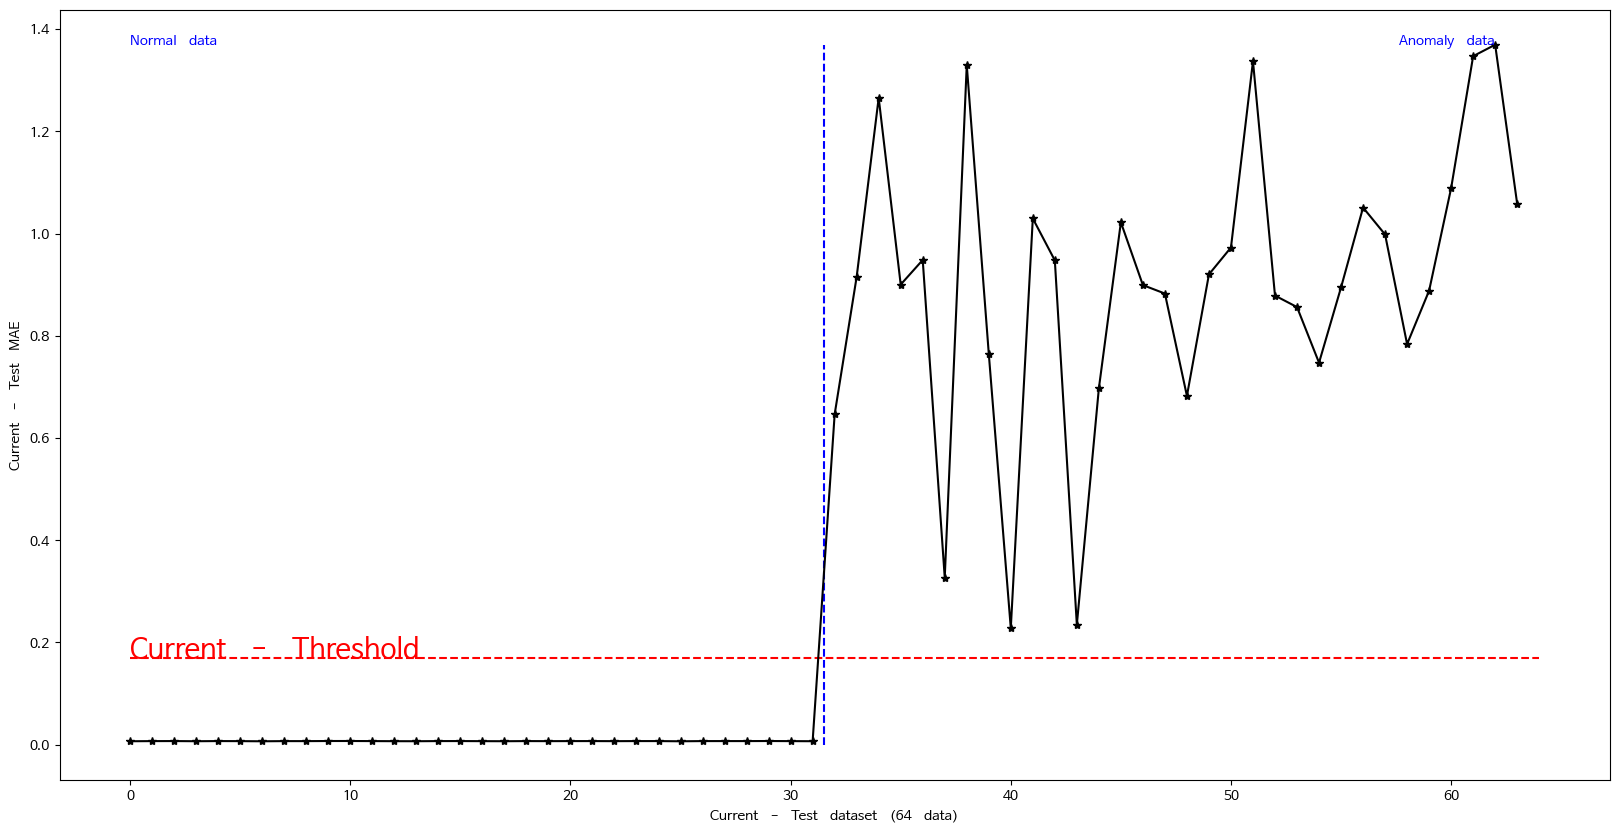

In [ ]:
plt.figure(figsize=(20,	10))
plt.text(x=0, y=max(cur_mae_test), s='Normal	data', horizontalalignment='left', color='blue')
plt.text(x=62, y=max(cur_mae_test), s='Anomaly	data', horizontalalignment='right',	color='blue')
plt.vlines(x=31.5,	ymin=0,	ymax=max(cur_mae_test),	color='blue', linestyle='--')
plt.text(x=0, y=cur_threshold,	s='Current - Threshold', fontsize=20, color='red')
plt.hlines(y=cur_threshold,	xmin=0,	xmax=len(cur_mae_test),	color='red', linestyle='--')
plt.xlabel('Current	- Test	dataset	(64	data)')
plt.ylabel('Current	- Test	MAE')
plt.plot(cur_mae_test, color='black', marker='*')
plt.show()

### 모델, StandardScaler, 임계값 저장하기
-> FastAPI에서 다시 로딩하여 사용하기 위함. 다시 학습 할 필요 x

In [30]:
vib_model.save("welding_vib_model.keras")
cur_model.save("welding_cur_model.keras")

In [31]:
import joblib
joblib.dump(scaler_vib, 'welding_scaler_vib.pkl')
joblib.dump(scaler_cur, 'welding_scaler_cur.pkl')


['welding_scaler_cur.pkl']

In [32]:
import json
thresholds = {
    "vibration": float(vib_threshold),
    "current": float(cur_threshold)
}
with open("welding_thresholds.json", "w") as f:
    json.dump(thresholds, f)

## 데이터 증감 함수

In [47]:
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.metrics import (roc_curve, auc, precision_recall_curve, average_precision_score,
                           classification_report, confusion_matrix, accuracy_score,
                           precision_score, recall_score, f1_score)
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# Font warning 해결: matplotlib 한글 폰트 설정
plt.rcParams['font.family'] = ['DejaVu Sans', 'Malgun Gothic', 'AppleGothic', 'NanumGothic']
plt.rcParams['axes.unicode_minus'] = False

In [48]:
def run_unified_evaluation_system(vib_model, cur_model, vib_test_dataset, cur_test_dataset,
                                vib_threshold=None, cur_threshold=None,
                                perform_augmentation=True, target_size_per_class=100):
    """
    통합된 평가 시스템 실행
    """
    print("="*60)
    print("통합 모델 성능 평가 시스템")
    print("="*60)

    # 실제 라벨 생성
    vib_true_labels, cur_true_labels = create_ground_truth_labels(vib_test_dataset, cur_test_dataset)

    # 원본 데이터 평가
    print("\n" + "="*40)
    print("원본 데이터 평가")
    print("="*40)

    vib_original_results = unified_autoencoder_evaluation(
        vib_model, vib_test_dataset, vib_true_labels, "진동", vib_threshold
    )

    cur_original_results = unified_autoencoder_evaluation(
        cur_model, cur_test_dataset, cur_true_labels, "전류", cur_threshold
    )

    # 데이터 증강 및 평가
    if perform_augmentation:
        print("\n" + "="*40)
        print("데이터 증강")
        print("="*40)

        # 진동 데이터 증강
        vib_normal_indices = list(range(16))
        vib_anomaly_indices = list(range(16, 32))

        vib_augmented_dataset, vib_augmented_labels = augment_frequency_dataset(
            vib_test_dataset, vib_normal_indices, vib_anomaly_indices, target_size_per_class
        )

        # 전류 데이터 증강
        cur_normal_indices = list(range(32))
        cur_anomaly_indices = list(range(32, 64))

        cur_augmented_dataset, cur_augmented_labels = augment_frequency_dataset(
            cur_test_dataset, cur_normal_indices, cur_anomaly_indices, target_size_per_class
        )

        print(f"\n데이터 증강이 완료되었습니다!")
        print(f"진동 데이터: {vib_test_dataset.shape} -> {vib_augmented_dataset.shape}")
        print(f"전류 데이터: {cur_test_dataset.shape} -> {cur_augmented_dataset.shape}")

        # 증강 데이터 평가
        print("\n" + "="*40)
        print("증강 데이터 평가")
        print("="*40)

        vib_augmented_results = unified_autoencoder_evaluation(
            vib_model, vib_augmented_dataset, vib_augmented_labels, "진동 (증강)", vib_threshold
        )

        cur_augmented_results = unified_autoencoder_evaluation(
            cur_model, cur_augmented_dataset, cur_augmented_labels, "전류 (증강)", cur_threshold
        )

        # 성능 비교
        print("\n" + "="*40)
        print("성능 비교")
        print("="*40)

        compare_performance_unified(vib_original_results, vib_augmented_results, "진동")
        compare_performance_unified(cur_original_results, cur_augmented_results, "전류")

        # 최종 요약 (원본 코드 스타일)
        print("\n" + "="*60)
        print("최종 요약")
        print("="*60)

        if 'optimized' in vib_original_results and 'optimized' in vib_augmented_results:
            vib_orig_auc = vib_original_results['optimized']['roc_auc']
            vib_aug_auc = vib_augmented_results['optimized']['metrics']['roc_auc']
            print(f"\n진동 데이터:")
            print(f"  원본 ROC AUC: {vib_orig_auc:.4f}")
            print(f"  증강 ROC AUC: {vib_aug_auc:.4f}")
            print(f"  개선 정도: {vib_aug_auc - vib_orig_auc:+.4f}")

        if 'optimized' in cur_original_results and 'optimized' in cur_augmented_results:
            cur_orig_auc = cur_original_results['optimized']['roc_auc']
            cur_aug_auc = cur_augmented_results['optimized']['metrics']['roc_auc']
            print(f"\n전류 데이터:")
            print(f"  원본 ROC AUC: {cur_orig_auc:.4f}")
            print(f"  증강 ROC AUC: {cur_aug_auc:.4f}")
            print(f"  개선 정도: {cur_aug_auc - cur_orig_auc:+.4f}")

        # 권장사항 (원본 코드 스타일)
        print(f"\n권장사항:")
        if 'optimized' in vib_augmented_results and vib_augmented_results['optimized']['metrics']['roc_auc'] < 0.9:
            print("- 진동 모델 성능이 낮습니다. 모델 구조나 하이퍼파라미터 조정을 고려하세요.")
        if 'optimized' in cur_augmented_results and cur_augmented_results['optimized']['metrics']['roc_auc'] < 0.9:
            print("- 전류 모델 성능이 낮습니다. 모델 구조나 하이퍼파라미터 조정을 고려하세요.")

        if ('optimized' in vib_original_results and 'optimized' in vib_augmented_results and
            vib_augmented_results['optimized']['metrics']['roc_auc'] - vib_original_results['optimized']['roc_auc'] < 0):
            print("- 데이터 증강이 진동 모델 성능을 저하시켰습니다. 증강 파라미터 조정을 고려하세요.")
        if ('optimized' in cur_original_results and 'optimized' in cur_augmented_results and
            cur_augmented_results['optimized']['metrics']['roc_auc'] - cur_original_results['optimized']['roc_auc'] < 0):
            print("- 데이터 증강이 전류 모델 성능을 저하시켰습니다. 증강 파라미터 조정을 고려하세요.")

        print("\n데이터 증강을 통해 더욱 신뢰성 있는 성능 평가가 가능해졌습니다!")

        return {
            'vibration': {
                'original': vib_original_results,
                'augmented': vib_augmented_results,
                'augmented_dataset': vib_augmented_dataset,
                'augmented_labels': vib_augmented_labels
            },
            'current': {
                'original': cur_original_results,
                'augmented': cur_augmented_results,
                'augmented_dataset': cur_augmented_dataset,
                'augmented_labels': cur_augmented_labels
            }
        }

    else:
        return {
            'vibration': {'original': vib_original_results},
            'current': {'original': cur_original_results}
        }


def add_frequency_noise(data, noise_factor=0.02):
    """Add noise to frequency domain data"""
    noise = np.random.normal(0, noise_factor, data.shape)
    freq_weights = np.linspace(0.5, 1.5, data.shape[1])
    noise = noise * freq_weights.reshape(1, -1, 1)
    return data + noise

def frequency_shift(data, shift_ratio=0.05):
    """Frequency axis shift"""
    shift_amount = int(data.shape[1] * shift_ratio * np.random.uniform(-1, 1))
    if shift_amount == 0:
        return data

    shifted_data = data.copy()
    if shift_amount > 0:
        shifted_data[:, shift_amount:] = data[:, :-shift_amount]
        shifted_data[:, :shift_amount] = 0
    else:
        shifted_data[:, :shift_amount] = data[:, -shift_amount:]
        shifted_data[:, shift_amount:] = 0

    return shifted_data

def amplitude_scaling(data, scale_range=(0.8, 1.2)):
    """Amplitude scaling"""
    scale = np.random.uniform(scale_range[0], scale_range[1])
    return data * scale

def frequency_band_dropout(data, dropout_prob=0.1, band_size=10):
    """Frequency band dropout"""
    data_copy = data.copy()
    num_bands = data.shape[1] // band_size

    for i in range(num_bands):
        if np.random.random() < dropout_prob:
            start_idx = i * band_size
            end_idx = min((i + 1) * band_size, data.shape[1])
            data_copy[:, start_idx:end_idx] = 0

    return data_copy

def frequency_masking(data, mask_ratio=0.1):
    """Frequency masking"""
    data_copy = data.copy()
    mask_size = int(data.shape[1] * mask_ratio)
    mask_start = np.random.randint(0, data.shape[1] - mask_size)
    data_copy[:, mask_start:mask_start + mask_size] = 0
    return data_copy

def frequency_smoothing(data, window_size=5):
    """Frequency domain smoothing"""
    data_copy = data.copy()
    for i in range(window_size, data.shape[1] - window_size):
        data_copy[:, i] = np.mean(data[:, i-window_size:i+window_size+1], axis=1, keepdims=True)
    return data_copy

def augment_frequency_dataset(dataset, normal_indices, anomaly_indices, target_size_per_class=100):
    """
    Augment frequency domain dataset for welding process
    """
    augmentation_methods = [
        add_frequency_noise,
        frequency_shift,
        amplitude_scaling,
        frequency_band_dropout,
        frequency_masking,
        frequency_smoothing
    ]

    normal_data = dataset[normal_indices]
    anomaly_data = dataset[anomaly_indices]

    print(f"Original normal data: {len(normal_data)} samples")
    print(f"Original anomaly data: {len(anomaly_data)} samples")

    # Augment normal data
    augmented_normal = [normal_data]
    augmented_normal_labels = [np.zeros(len(normal_data))]

    current_normal_size = len(normal_data)
    while current_normal_size < target_size_per_class:
        for method in augmentation_methods:
            if current_normal_size >= target_size_per_class:
                break

            idx = np.random.randint(0, len(normal_data))
            sample = normal_data[idx:idx+1].copy()

            try:
                if method == add_frequency_noise:
                    augmented_sample = method(sample, noise_factor=np.random.uniform(0.005, 0.02))
                elif method == frequency_shift:
                    augmented_sample = method(sample, shift_ratio=np.random.uniform(0.01, 0.03))
                elif method == amplitude_scaling:
                    augmented_sample = method(sample, scale_range=(0.85, 1.15))
                elif method == frequency_band_dropout:
                    augmented_sample = method(sample, dropout_prob=0.05, band_size=8)
                elif method == frequency_masking:
                    augmented_sample = method(sample, mask_ratio=np.random.uniform(0.02, 0.08))
                elif method == frequency_smoothing:
                    augmented_sample = method(sample, window_size=np.random.randint(3, 7))
                else:
                    augmented_sample = method(sample)

                augmented_normal.append(augmented_sample)
                augmented_normal_labels.append(np.array([0]))
                current_normal_size += 1

            except Exception as e:
                print(f"Error during normal data augmentation ({method.__name__}): {e}")
                continue

    # Augment anomaly data
    augmented_anomaly = [anomaly_data]
    augmented_anomaly_labels = [np.ones(len(anomaly_data))]

    current_anomaly_size = len(anomaly_data)
    while current_anomaly_size < target_size_per_class:
        for method in augmentation_methods:
            if current_anomaly_size >= target_size_per_class:
                break

            idx = np.random.randint(0, len(anomaly_data))
            sample = anomaly_data[idx:idx+1].copy()

            try:
                if method == add_frequency_noise:
                    augmented_sample = method(sample, noise_factor=np.random.uniform(0.005, 0.02))
                elif method == frequency_shift:
                    augmented_sample = method(sample, shift_ratio=np.random.uniform(0.01, 0.03))
                elif method == amplitude_scaling:
                    augmented_sample = method(sample, scale_range=(0.85, 1.15))
                elif method == frequency_band_dropout:
                    augmented_sample = method(sample, dropout_prob=0.05, band_size=8)
                elif method == frequency_masking:
                    augmented_sample = method(sample, mask_ratio=np.random.uniform(0.02, 0.08))
                elif method == frequency_smoothing:
                    augmented_sample = method(sample, window_size=np.random.randint(3, 7))
                else:
                    augmented_sample = method(sample)

                augmented_anomaly.append(augmented_sample)
                augmented_anomaly_labels.append(np.array([1]))
                current_anomaly_size += 1

            except Exception as e:
                print(f"Error during anomaly data augmentation ({method.__name__}): {e}")
                continue

    # Combine results
    final_normal_data = np.concatenate(augmented_normal, axis=0)[:target_size_per_class]
    final_anomaly_data = np.concatenate(augmented_anomaly, axis=0)[:target_size_per_class]
    final_normal_labels = np.concatenate(augmented_normal_labels, axis=0)[:target_size_per_class]
    final_anomaly_labels = np.concatenate(augmented_anomaly_labels, axis=0)[:target_size_per_class]

    # Final dataset
    final_dataset = np.concatenate([final_normal_data, final_anomaly_data], axis=0)
    final_labels = np.concatenate([final_normal_labels, final_anomaly_labels], axis=0)

    # Shuffle
    indices = np.random.permutation(len(final_dataset))
    final_dataset = final_dataset[indices]
    final_labels = final_labels[indices]

    return final_dataset, final_labels

## 성능 평가 함수

In [49]:

# 한글 폰트 설정 함수 추가
def setup_korean_font():
    """한글 폰트 설정 (더 강력한 버전)"""
    import platform
    import matplotlib.font_manager as fm

    # 시스템별 한글 폰트 경로 설정
    system = platform.system()

    try:
        if system == 'Windows':
            # Windows 한글 폰트들
            font_candidates = [
                'C:/Windows/Fonts/malgun.ttf',  # 맑은 고딕
                'C:/Windows/Fonts/gulim.ttc',   # 굴림
                'Malgun Gothic', 'gulim', 'dotum'
            ]
        elif system == 'Darwin':  # macOS
            font_candidates = [
                '/System/Library/Fonts/AppleGothic.ttf',
                'AppleGothic', 'Apple SD Gothic Neo'
            ]
        else:  # Linux
            font_candidates = [
                '/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
                'NanumGothic', 'DejaVu Sans'
            ]

        # 폰트 설정 시도
        for font in font_candidates:
            try:
                if font.endswith('.ttf') or font.endswith('.ttc'):
                    # 파일 경로인 경우
                    prop = fm.FontProperties(fname=font)
                    plt.rcParams['font.family'] = prop.get_name()
                else:
                    # 폰트 이름인 경우
                    plt.rcParams['font.family'] = font

                plt.rcParams['axes.unicode_minus'] = False

                # 테스트
                fig, ax = plt.subplots(figsize=(1, 1))
                ax.text(0.5, 0.5, '한글테스트', ha='center', va='center')
                plt.close(fig)

                print(f"한글 폰트 설정 완료: {font}")
                return True

            except Exception as e:
                continue

        # 모든 폰트 실패시 기본 설정
        print("한글 폰트를 찾을 수 없어 기본 설정을 사용합니다.")
        plt.rcParams['font.family'] = 'DejaVu Sans'
        plt.rcParams['axes.unicode_minus'] = False
        return False

    except Exception as e:
        print(f"폰트 설정 중 오류: {e}")
        plt.rcParams['font.family'] = 'DejaVu Sans'
        plt.rcParams['axes.unicode_minus'] = False
        return False

# 초기 폰트 설정 실행
setup_korean_font()


def calculate_comprehensive_metrics(y_true, y_pred, mae_scores):
    """
    포괄적인 성능 지표 계산 (두 코드의 지표 통합)
    """
    # 기본 분류 지표
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # 특이도 (Specificity)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # ROC-AUC 및 PR-AUC
    if len(np.unique(y_true)) > 1:
        # ROC curve
        fpr, tpr, _ = roc_curve(y_true, mae_scores)
        roc_auc = auc(fpr, tpr)

        # Precision-Recall curve
        precision_curve, recall_curve, _ = precision_recall_curve(y_true, mae_scores)
        avg_precision = average_precision_score(y_true, mae_scores)
    else:
        roc_auc = 0.0
        avg_precision = 0.0

    # 재구성 오차 통계
    normal_scores = mae_scores[y_true == 0]
    anomaly_scores = mae_scores[y_true == 1]

    metrics = {
        # 분류 성능 지표
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'specificity': specificity,

        # ROC 및 PR 곡선 지표
        'roc_auc': roc_auc,
        'avg_precision': avg_precision,

        # Confusion Matrix 요소
        'true_positive': tp,
        'true_negative': tn,
        'false_positive': fp,
        'false_negative': fn,

        # 재구성 오차 통계
        'mae_mean': np.mean(mae_scores),
        'mae_std': np.std(mae_scores),
        'mae_min': np.min(mae_scores),
        'mae_max': np.max(mae_scores),
        'normal_mae_mean': np.mean(normal_scores) if len(normal_scores) > 0 else 0,
        'normal_mae_std': np.std(normal_scores) if len(normal_scores) > 0 else 0,
        'anomaly_mae_mean': np.mean(anomaly_scores) if len(anomaly_scores) > 0 else 0,
        'anomaly_mae_std': np.std(anomaly_scores) if len(anomaly_scores) > 0 else 0,
    }

    return metrics

def optimize_threshold_youden(y_true, mae_values):
    """
    Youden's J statistic을 사용한 최적 임계치 찾기 (원본 코드 방식)
    """
    # ROC curve에서 실제 threshold 값들 사용
    fpr, tpr, thresholds = roc_curve(y_true, mae_values)

    # Youden's J statistic으로 최적 임계치 찾기
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    # 최적 임계치로 예측 및 지표 계산
    y_pred_optimal = (mae_values > optimal_threshold).astype(int)
    optimal_metrics = calculate_comprehensive_metrics(y_true, y_pred_optimal, mae_values)

    return optimal_threshold, optimal_metrics

def print_unified_performance_report(metrics, data_type="", threshold=None):
    """
    통일된 형식의 성능 리포트 출력
    """
    print(f"\n{'='*60}")
    print(f"{data_type} 데이터 성능 평가 결과")
    print(f"{'='*60}")

    if threshold is not None:
        print(f"최적 임계치: {threshold:.6f}")

    print(f"\n--- 분류 성능 지표 ---")
    print(f"정확도 (Accuracy):     {metrics['accuracy']:.4f} ({metrics['accuracy']*100:.2f}%)")
    print(f"정밀도 (Precision):    {metrics['precision']:.4f} ({metrics['precision']*100:.2f}%)")
    print(f"재현율 (Recall):       {metrics['recall']:.4f} ({metrics['recall']*100:.2f}%)")
    print(f"F1-점수 (F1-Score):    {metrics['f1_score']:.4f} ({metrics['f1_score']*100:.2f}%)")
    print(f"특이도 (Specificity):  {metrics['specificity']:.4f} ({metrics['specificity']*100:.2f}%)")

    print(f"\n--- ROC 및 PR 곡선 지표 ---")
    print(f"ROC AUC:              {metrics['roc_auc']:.4f}")
    print(f"평균 정밀도 (AP):      {metrics['avg_precision']:.4f}")

    print(f"\n--- 재구성 오차 통계 ---")
    print(f"평균 MAE:             {metrics['mae_mean']:.6f}")
    print(f"표준편차 MAE:         {metrics['mae_std']:.6f}")
    print(f"최소 MAE:             {metrics['mae_min']:.6f}")
    print(f"최대 MAE:             {metrics['mae_max']:.6f}")

    print(f"\n--- 클래스별 재구성 오차 ---")
    print(f"정상 데이터 평균:      {metrics['normal_mae_mean']:.6f} ± {metrics['normal_mae_std']:.6f}")
    print(f"이상 데이터 평균:      {metrics['anomaly_mae_mean']:.6f} ± {metrics['anomaly_mae_std']:.6f}")

    print(f"\n--- 혼동 행렬 ---")
    print(f"참 양성 (TP):         {metrics['true_positive']}")
    print(f"참 음성 (TN):         {metrics['true_negative']}")
    print(f"거짓 양성 (FP):       {metrics['false_positive']}")
    print(f"거짓 음성 (FN):       {metrics['false_negative']}")

    # 성능 해석
    print(f"\n--- 성능 해석 ---")
    if metrics['accuracy'] >= 0.95:
        print("→ 매우 우수한 성능")
    elif metrics['accuracy'] >= 0.90:
        print("→ 우수한 성능")
    elif metrics['accuracy'] >= 0.80:
        print("→ 양호한 성능")
    else:
        print("→ 개선이 필요한 성능")

def plot_unified_performance_analysis(y_true, mae_values, best_threshold, data_type=""):
    """
    통일된 성능 분석 시각화 (한글 폰트 적용)
    """
    # 그래프별로 한글 폰트 재설정
    setup_korean_font()

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Reconstruction error histogram
    normal_scores = mae_values[y_true == 0]
    anomaly_scores = mae_values[y_true == 1]

    axes[0, 0].hist(normal_scores, bins=30, alpha=0.7, label='정상', color='blue', density=True)
    axes[0, 0].hist(anomaly_scores, bins=30, alpha=0.7, label='이상', color='red', density=True)
    axes[0, 0].axvline(best_threshold, color='green', linestyle='--',
                      label=f'최적 임계치: {best_threshold:.4f}')
    axes[0, 0].set_xlabel('재구성 오차 (MAE)', fontsize=12)
    axes[0, 0].set_ylabel('밀도', fontsize=12)
    axes[0, 0].set_title(f'{data_type} - 재구성 오차 분포', fontsize=14, pad=20)
    axes[0, 0].legend(fontsize=10)
    axes[0, 0].grid(True, alpha=0.3)

    # 2. ROC curve
    if len(np.unique(y_true)) > 1:
        fpr, tpr, _ = roc_curve(y_true, mae_values)
        roc_auc = auc(fpr, tpr)
        axes[0, 1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC 곡선 (AUC = {roc_auc:.4f})')
        axes[0, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[0, 1].set_xlim([0.0, 1.0])
        axes[0, 1].set_ylim([0.0, 1.05])
        axes[0, 1].set_xlabel('거짓 양성률 (FPR)', fontsize=12)
        axes[0, 1].set_ylabel('참 양성률 (TPR)', fontsize=12)
        axes[0, 1].set_title(f'{data_type} - ROC 곡선', fontsize=14, pad=20)
        axes[0, 1].legend(loc="lower right", fontsize=10)
        axes[0, 1].grid(True, alpha=0.3)

    # 3. Precision-Recall curve
    if len(np.unique(y_true)) > 1:
        precision, recall, _ = precision_recall_curve(y_true, mae_values)
        avg_precision = average_precision_score(y_true, mae_values)
        axes[1, 0].plot(recall, precision, color='blue', lw=2, label=f'PR 곡선 (AP = {avg_precision:.4f})')
        axes[1, 0].set_xlabel('재현율 (Recall)', fontsize=12)
        axes[1, 0].set_ylabel('정밀도 (Precision)', fontsize=12)
        axes[1, 0].set_title(f'{data_type} - 정밀도-재현율 곡선', fontsize=14, pad=20)
        axes[1, 0].legend(fontsize=10)
        axes[1, 0].grid(True, alpha=0.3)

    # 4. Confusion matrix
    y_pred_best = (mae_values > best_threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred_best)

    # 한글 라벨로 heatmap 생성
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1],
                xticklabels=['정상', '이상'], yticklabels=['정상', '이상'],
                annot_kws={'fontsize': 12})
    axes[1, 1].set_title(f'{data_type} - 혼동 행렬', fontsize=14, pad=20)
    axes[1, 1].set_xlabel('예측값', fontsize=12)
    axes[1, 1].set_ylabel('실제값', fontsize=12)

    # 전체 레이아웃 조정
    plt.tight_layout(pad=3.0)

    # 폰트 강제 적용
    for ax in axes.flat:
        for text in ax.texts:
            text.set_fontsize(10)

    plt.show()

def unified_autoencoder_evaluation(model, test_dataset, test_labels, data_type="",
                                 original_threshold=None, use_optimization=True):
    """
    통합된 오토인코더 성능 평가 함수 (원본 코드 방식 적용)
    """
    print(f"\n=== {data_type} 데이터 오토인코더 평가 ===")

    # 1. 예측 및 재구성 오차 계산
    predictions = model.predict(test_dataset, verbose=0)
    mae_scores = np.mean(np.abs(predictions - test_dataset), axis=1).flatten()

    # 재구성 오차 통계 출력 (원본 코드 스타일)
    print(f"재구성 오차 통계:")
    print(f"  평균: {np.mean(mae_scores):.6f}")
    print(f"  표준편차: {np.std(mae_scores):.6f}")
    print(f"  최소값: {np.min(mae_scores):.6f}")
    print(f"  최대값: {np.max(mae_scores):.6f}")

    # 클래스별 재구성 오차 분석
    normal_scores = mae_scores[test_labels == 0]
    anomaly_scores = mae_scores[test_labels == 1]

    print(f"\n클래스별 재구성 오차:")
    print(f"  정상 데이터 평균: {np.mean(normal_scores):.6f} ± {np.std(normal_scores):.6f}")
    print(f"  이상 데이터 평균: {np.mean(anomaly_scores):.6f} ± {np.std(anomaly_scores):.6f}")

    results = {}

    # 2. Youden's J statistic으로 최적 임계치 찾기
    if use_optimization:
        # ROC curve 계산
        fpr, tpr, thresholds = roc_curve(test_labels, mae_scores)
        roc_auc = auc(fpr, tpr)

        # Youden's J statistic으로 최적 임계치 찾기
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]

        print(f"\n성능 지표:")
        print(f"  ROC AUC: {roc_auc:.4f}")
        print(f"  최적 임계치: {optimal_threshold:.6f}")

        # 최적 임계치로 분류 성능 평가
        predictions_binary = (mae_scores > optimal_threshold).astype(int)

        print(f"\n분류 성능 (임계치: {optimal_threshold:.6f}):")
        print(classification_report(test_labels, predictions_binary,
                                  target_names=['정상', '이상'], digits=4))

        # 포괄적인 지표 계산
        optimal_metrics = calculate_comprehensive_metrics(test_labels, predictions_binary, mae_scores)

        results['optimized'] = {
            'metrics': optimal_metrics,
            'threshold': optimal_threshold,
            'predictions': predictions_binary,
            'roc_auc': roc_auc,
            'fpr': fpr,
            'tpr': tpr,
            'thresholds': thresholds
        }

        # 시각화
        plot_unified_performance_analysis(test_labels, mae_scores, optimal_threshold, data_type)

    # 3. 기존 임계치로 평가 (있는 경우)
    if original_threshold is not None:
        print(f"\n--- 기존 임계치 ({original_threshold:.6f}) 비교 ---")
        y_pred_original = (mae_scores > original_threshold).astype(int)
        original_metrics = calculate_comprehensive_metrics(test_labels, y_pred_original, mae_scores)

        print(f"기존 임계치 정확도: {original_metrics['accuracy']:.4f}")
        print(f"기존 임계치 F1-점수: {original_metrics['f1_score']:.4f}")

        results['original'] = {
            'metrics': original_metrics,
            'threshold': original_threshold,
            'predictions': y_pred_original
        }

    # 4. 기본 결과 저장
    results['mae_scores'] = mae_scores
    results['true_labels'] = test_labels

    return results

def compare_performance_unified(original_results, augmented_results, data_type=""):
    """
    원본 vs 증강 데이터 성능 비교 (원본 코드 스타일)
    """
    print(f"\n=== {data_type} 데이터: 원본 vs 증강 데이터 성능 비교 ===")

    # ROC AUC와 Average Precision만 비교 (원본 코드 방식)
    metrics = ['roc_auc', 'avg_precision']
    metric_names = ['ROC AUC', '평균 정밀도']

    if 'optimized' in original_results and 'optimized' in augmented_results:
        orig_roc_auc = original_results['optimized']['roc_auc']
        aug_roc_auc = augmented_results['optimized']['metrics']['roc_auc']

        orig_avg_precision = original_results['optimized']['metrics']['avg_precision']
        aug_avg_precision = augmented_results['optimized']['metrics']['avg_precision']

        print(f"ROC AUC:")
        print(f"  원본 데이터: {orig_roc_auc:.4f}")
        print(f"  증강 데이터: {aug_roc_auc:.4f}")
        print(f"  차이: {aug_roc_auc - orig_roc_auc:+.4f}")
        print()

        print(f"평균 정밀도:")
        print(f"  원본 데이터: {orig_avg_precision:.4f}")
        print(f"  증강 데이터: {aug_avg_precision:.4f}")
        print(f"  차이: {aug_avg_precision - orig_avg_precision:+.4f}")
        print()

# =====================================================
# 메인 실행 함수들
# =====================================================

def create_ground_truth_labels(vib_test_dataset, cur_test_dataset):
    """
    테스트 데이터셋의 실제 라벨 생성
    """
    # 진동 데이터: 처음 16개는 정상(0), 나머지 16개는 이상(1)
    vib_true_labels = np.concatenate([np.zeros(16), np.ones(16)])

    # 전류 데이터: 처음 32개는 정상(0), 나머지 32개는 이상(1)
    cur_true_labels = np.concatenate([np.zeros(32), np.ones(32)])

    return vib_true_labels, cur_true_labels

def run_unified_evaluation_system(vib_model, cur_model, vib_test_dataset, cur_test_dataset,
                                vib_threshold=None, cur_threshold=None,
                                perform_augmentation=True, target_size_per_class=100):
    """
    통합된 평가 시스템 실행
    """
    print("="*60)
    print("UNIFIED MODEL PERFORMANCE EVALUATION SYSTEM")
    print("="*60)

    # 실제 라벨 생성
    vib_true_labels, cur_true_labels = create_ground_truth_labels(vib_test_dataset, cur_test_dataset)

    # 원본 데이터 평가
    print("\n" + "="*40)
    print("ORIGINAL DATA EVALUATION")
    print("="*40)

    vib_original_results = unified_autoencoder_evaluation(
        vib_model, vib_test_dataset, vib_true_labels, "Vibration", vib_threshold
    )

    cur_original_results = unified_autoencoder_evaluation(
        cur_model, cur_test_dataset, cur_true_labels, "Current", cur_threshold
    )

    # 데이터 증강 및 평가
    if perform_augmentation:
        print("\n" + "="*40)
        print("DATA AUGMENTATION")
        print("="*40)

        # 진동 데이터 증강
        vib_normal_indices = list(range(16))
        vib_anomaly_indices = list(range(16, 32))

        vib_augmented_dataset, vib_augmented_labels = augment_frequency_dataset(
            vib_test_dataset, vib_normal_indices, vib_anomaly_indices, target_size_per_class
        )

        # 전류 데이터 증강
        cur_normal_indices = list(range(32))
        cur_anomaly_indices = list(range(32, 64))

        cur_augmented_dataset, cur_augmented_labels = augment_frequency_dataset(
            cur_test_dataset, cur_normal_indices, cur_anomaly_indices, target_size_per_class
        )

        print(f"\nAugmentation completed!")
        print(f"Vibration data: {vib_test_dataset.shape} -> {vib_augmented_dataset.shape}")
        print(f"Current data: {cur_test_dataset.shape} -> {cur_augmented_dataset.shape}")

        # 증강 데이터 평가
        print("\n" + "="*40)
        print("AUGMENTED DATA EVALUATION")
        print("="*40)

        vib_augmented_results = unified_autoencoder_evaluation(
            vib_model, vib_augmented_dataset, vib_augmented_labels, "Vibration (Augmented)", vib_threshold
        )

        cur_augmented_results = unified_autoencoder_evaluation(
            cur_model, cur_augmented_dataset, cur_augmented_labels, "Current (Augmented)", cur_threshold
        )

        # 성능 비교
        print("\n" + "="*40)
        print("PERFORMANCE COMPARISON")
        print("="*40)

        compare_performance_unified(vib_original_results, vib_augmented_results, "Vibration")
        compare_performance_unified(cur_original_results, cur_augmented_results, "Current")

        # 최종 요약
        print("\n" + "="*60)
        print("FINAL SUMMARY")
        print("="*60)

        if 'optimized' in vib_original_results and 'optimized' in vib_augmented_results:
            vib_orig_auc = vib_original_results['optimized']['metrics']['roc_auc']
            vib_aug_auc = vib_augmented_results['optimized']['metrics']['roc_auc']
            print(f"\nVibration Model:")
            print(f"  Original ROC AUC:   {vib_orig_auc:.4f}")
            print(f"  Augmented ROC AUC:  {vib_aug_auc:.4f}")
            print(f"  Improvement:        {vib_aug_auc - vib_orig_auc:+.4f}")

        if 'optimized' in cur_original_results and 'optimized' in cur_augmented_results:
            cur_orig_auc = cur_original_results['optimized']['metrics']['roc_auc']
            cur_aug_auc = cur_augmented_results['optimized']['metrics']['roc_auc']
            print(f"\nCurrent Model:")
            print(f"  Original ROC AUC:   {cur_orig_auc:.4f}")
            print(f"  Augmented ROC AUC:  {cur_aug_auc:.4f}")
            print(f"  Improvement:        {cur_aug_auc - cur_orig_auc:+.4f}")

        return {
            'vibration': {
                'original': vib_original_results,
                'augmented': vib_augmented_results,
                'augmented_dataset': vib_augmented_dataset,
                'augmented_labels': vib_augmented_labels
            },
            'current': {
                'original': cur_original_results,
                'augmented': cur_augmented_results,
                'augmented_dataset': cur_augmented_dataset,
                'augmented_labels': cur_augmented_labels
            }
        }

    else:
        return {
            'vibration': {'original': vib_original_results},
            'current': {'original': cur_original_results}
        }


한글 폰트 설정 완료: /usr/share/fonts/truetype/nanum/NanumGothic.ttf


UNIFIED MODEL PERFORMANCE EVALUATION SYSTEM

ORIGINAL DATA EVALUATION

=== Vibration 데이터 오토인코더 평가 ===
재구성 오차 통계:
  평균: 0.717708
  표준편차: 0.825852
  최소값: 0.025010
  최대값: 2.674204

클래스별 재구성 오차:
  정상 데이터 평균: 0.026995 ± 0.001496
  이상 데이터 평균: 1.408421 ± 0.640227

성능 지표:
  ROC AUC: 1.0000
  최적 임계치: 0.366305

분류 성능 (임계치: 0.366305):
              precision    recall  f1-score   support

          정상     0.9412    1.0000    0.9697        16
          이상     1.0000    0.9375    0.9677        16

    accuracy                         0.9688        32
   macro avg     0.9706    0.9688    0.9687        32
weighted avg     0.9706    0.9688    0.9687        32

한글 폰트 설정 완료: /usr/share/fonts/truetype/nanum/NanumGothic.ttf


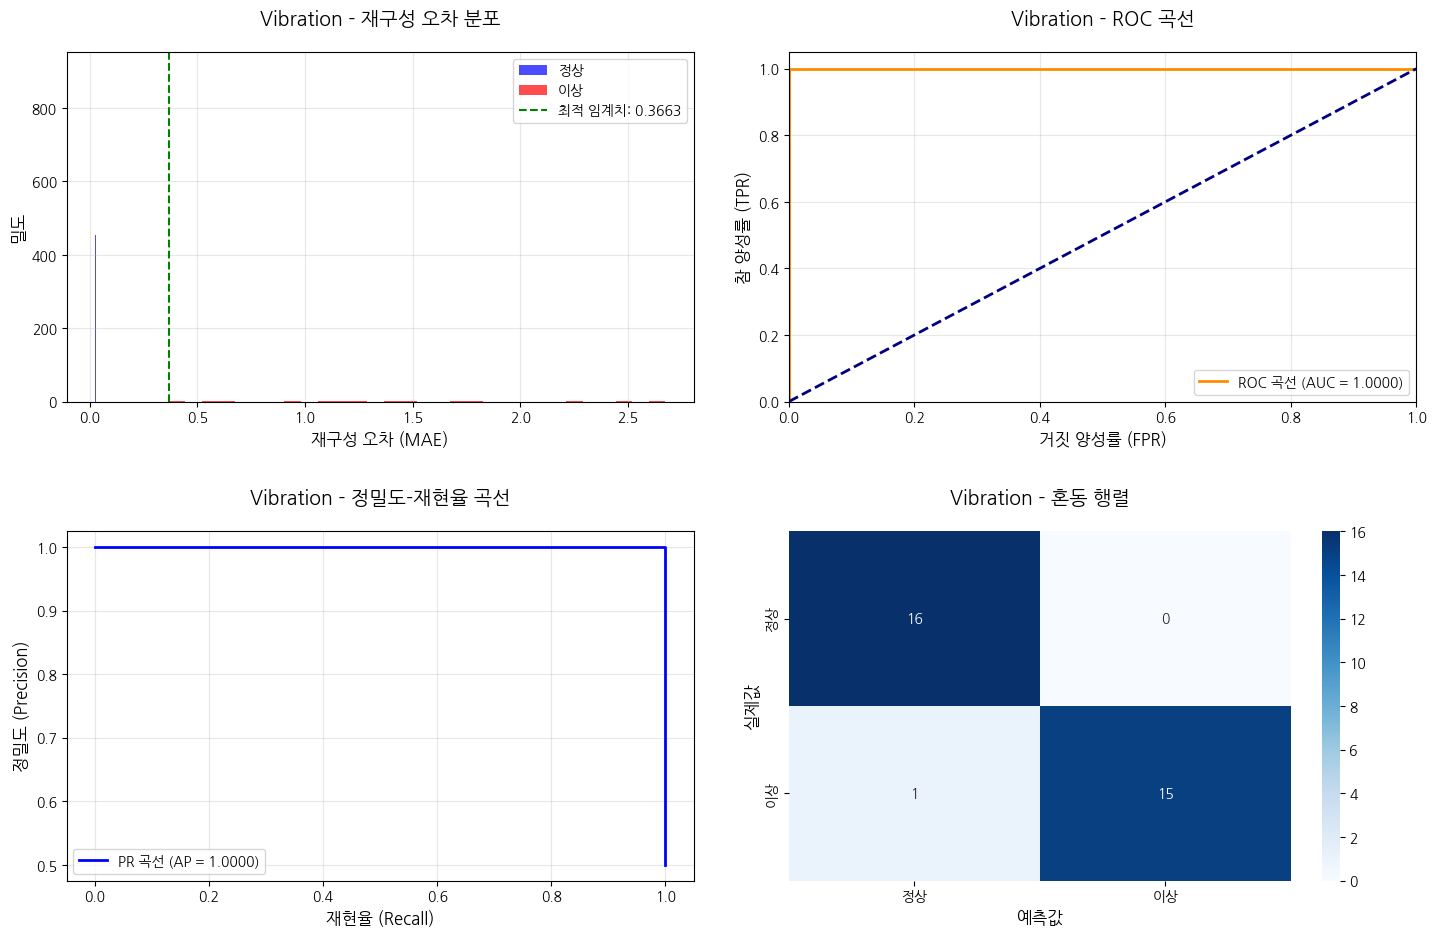


--- 기존 임계치 (0.068197) 비교 ---
기존 임계치 정확도: 1.0000
기존 임계치 F1-점수: 1.0000

=== Current 데이터 오토인코더 평가 ===
재구성 오차 통계:
  평균: 0.455232
  표준편차: 0.489800
  최소값: 0.006723
  최대값: 1.369329

클래스별 재구성 오차:
  정상 데이터 평균: 0.007032 ± 0.000145
  이상 데이터 평균: 0.903432 ± 0.279360

성능 지표:
  ROC AUC: 1.0000
  최적 임계치: 0.227925

분류 성능 (임계치: 0.227925):
              precision    recall  f1-score   support

          정상     0.9697    1.0000    0.9846        32
          이상     1.0000    0.9688    0.9841        32

    accuracy                         0.9844        64
   macro avg     0.9848    0.9844    0.9844        64
weighted avg     0.9848    0.9844    0.9844        64

한글 폰트 설정 완료: /usr/share/fonts/truetype/nanum/NanumGothic.ttf


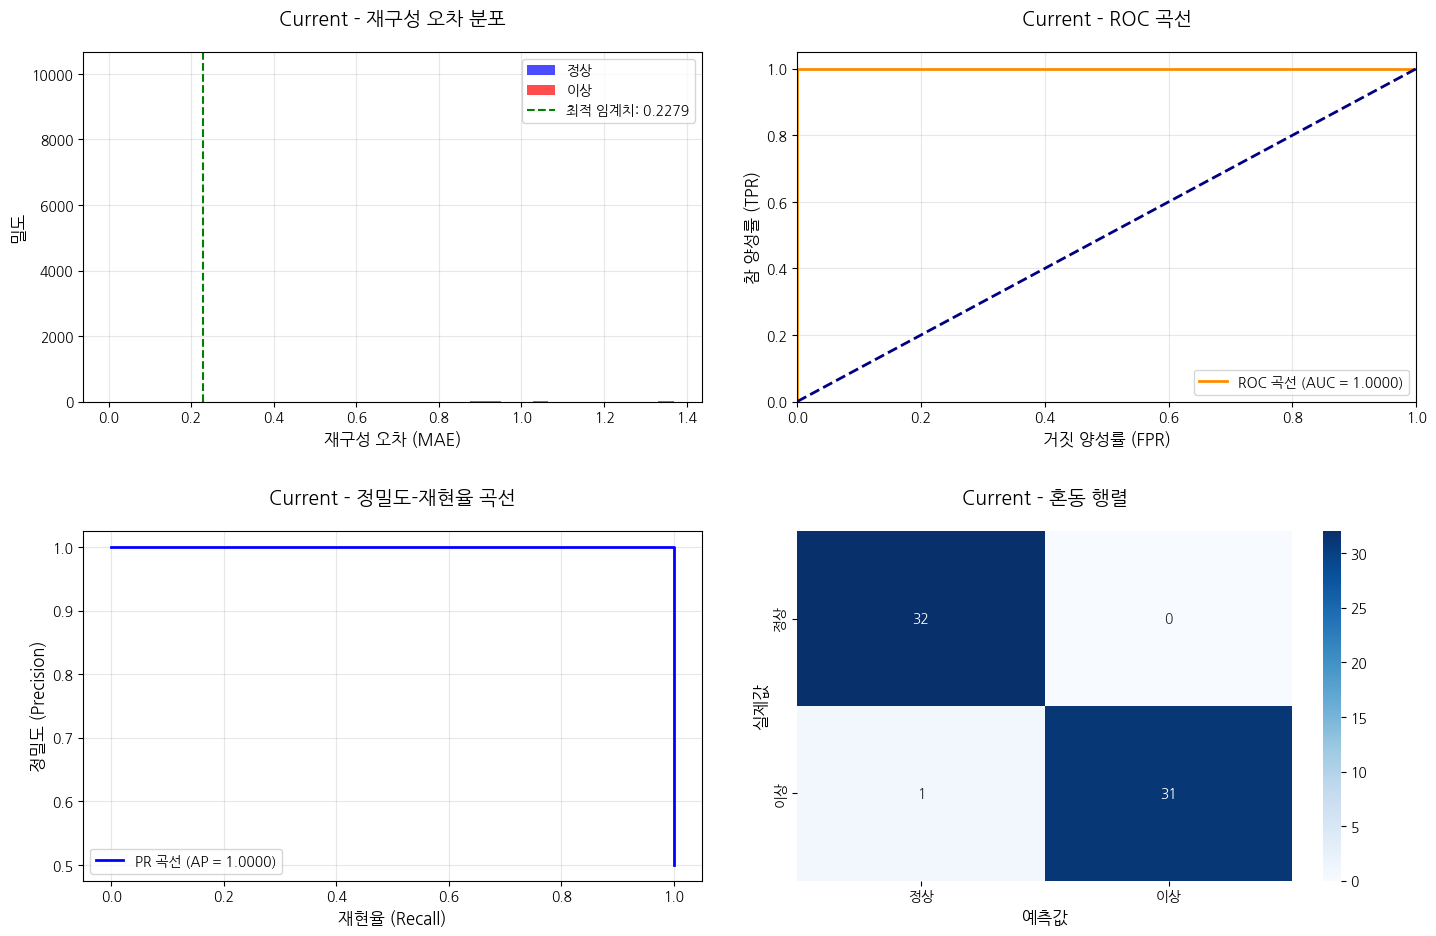


--- 기존 임계치 (0.170350) 비교 ---
기존 임계치 정확도: 1.0000
기존 임계치 F1-점수: 1.0000


In [50]:
# 원본 데이터만 평가
results = run_unified_evaluation_system(
    vib_model, cur_model,
    vib_test_dataset, cur_test_dataset,
    vib_threshold, cur_threshold,
    perform_augmentation=False
)

UNIFIED MODEL PERFORMANCE EVALUATION SYSTEM

ORIGINAL DATA EVALUATION

=== Vibration 데이터 오토인코더 평가 ===
재구성 오차 통계:
  평균: 0.717708
  표준편차: 0.825852
  최소값: 0.025010
  최대값: 2.674205

클래스별 재구성 오차:
  정상 데이터 평균: 0.026995 ± 0.001496
  이상 데이터 평균: 1.408421 ± 0.640227

성능 지표:
  ROC AUC: 1.0000
  최적 임계치: 0.366305

분류 성능 (임계치: 0.366305):
              precision    recall  f1-score   support

          정상     0.9412    1.0000    0.9697        16
          이상     1.0000    0.9375    0.9677        16

    accuracy                         0.9688        32
   macro avg     0.9706    0.9688    0.9687        32
weighted avg     0.9706    0.9688    0.9687        32

한글 폰트 설정 완료: /usr/share/fonts/truetype/nanum/NanumGothic.ttf


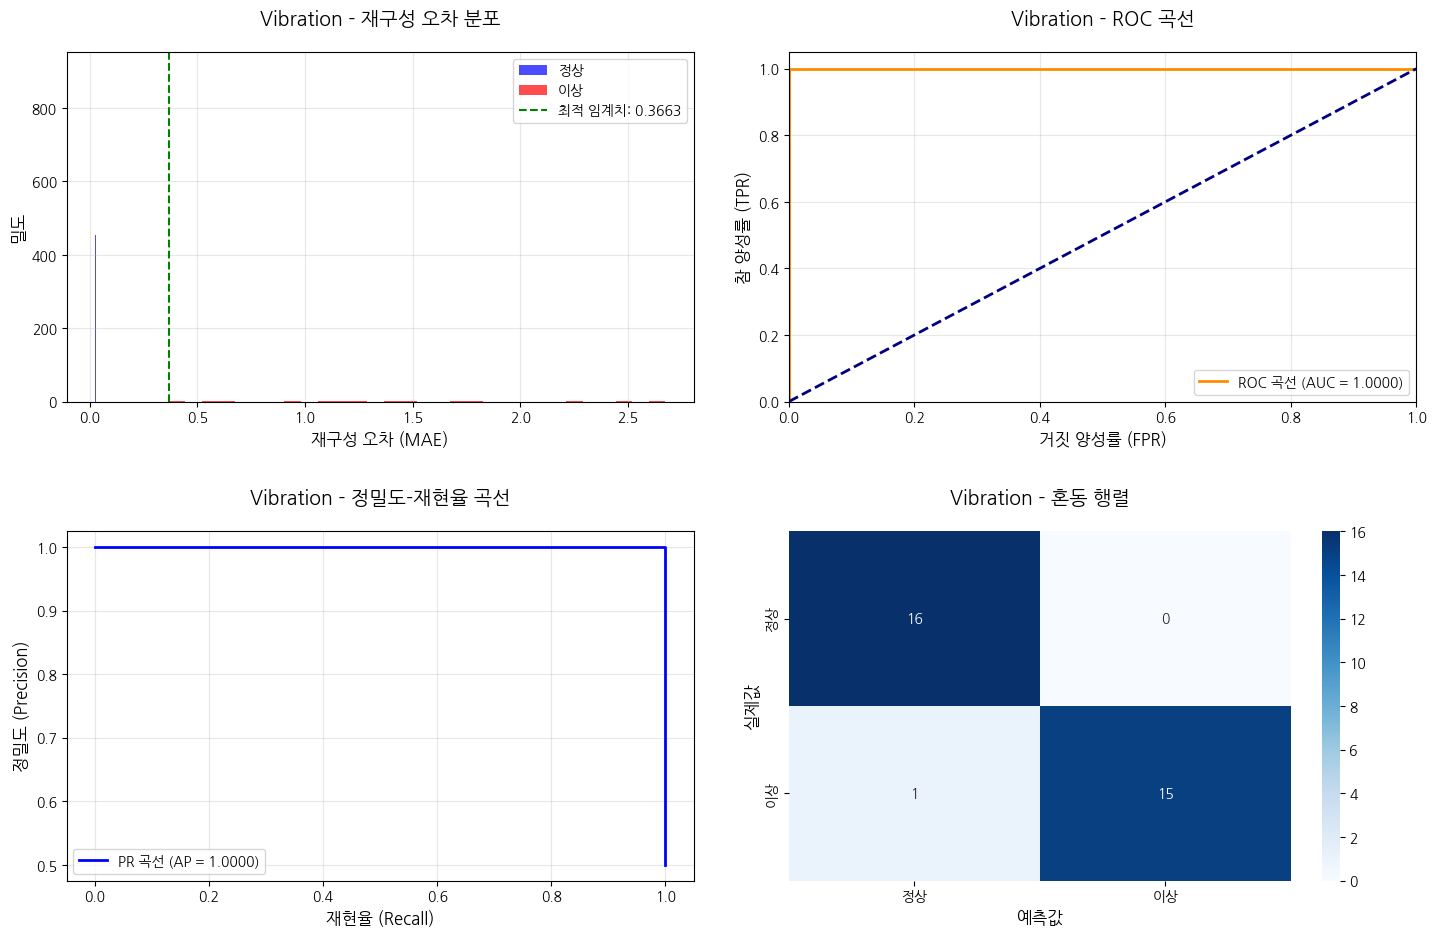


--- 기존 임계치 (0.068197) 비교 ---
기존 임계치 정확도: 1.0000
기존 임계치 F1-점수: 1.0000

=== Current 데이터 오토인코더 평가 ===
재구성 오차 통계:
  평균: 0.455232
  표준편차: 0.489800
  최소값: 0.006723
  최대값: 1.369329

클래스별 재구성 오차:
  정상 데이터 평균: 0.007032 ± 0.000145
  이상 데이터 평균: 0.903432 ± 0.279360

성능 지표:
  ROC AUC: 1.0000
  최적 임계치: 0.227925

분류 성능 (임계치: 0.227925):
              precision    recall  f1-score   support

          정상     0.9697    1.0000    0.9846        32
          이상     1.0000    0.9688    0.9841        32

    accuracy                         0.9844        64
   macro avg     0.9848    0.9844    0.9844        64
weighted avg     0.9848    0.9844    0.9844        64

한글 폰트 설정 완료: /usr/share/fonts/truetype/nanum/NanumGothic.ttf


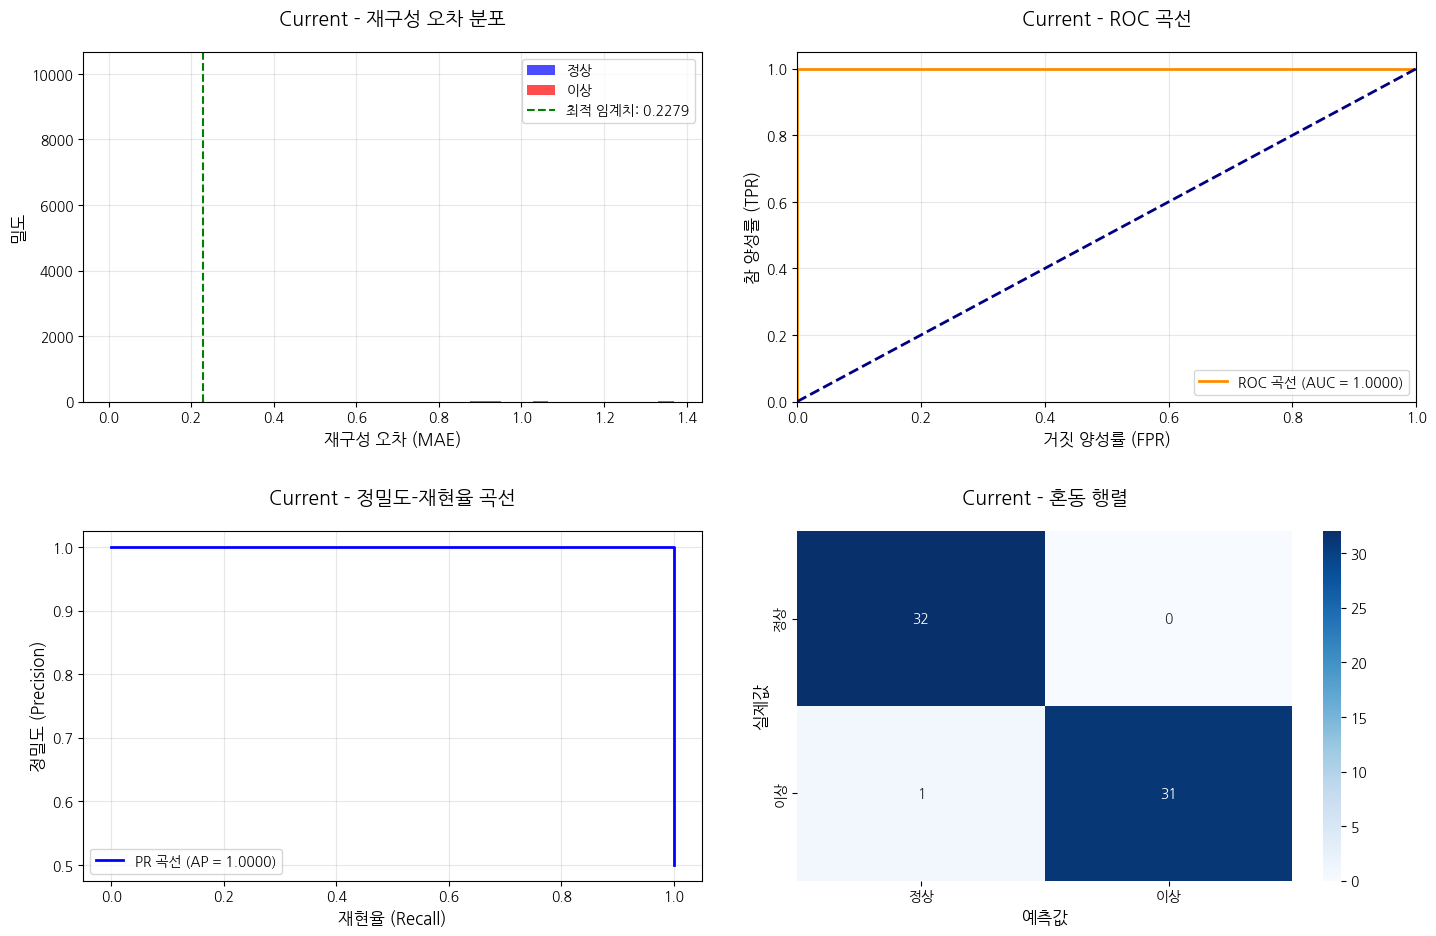


--- 기존 임계치 (0.170350) 비교 ---
기존 임계치 정확도: 1.0000
기존 임계치 F1-점수: 1.0000

DATA AUGMENTATION
Original normal data: 16 samples
Original anomaly data: 16 samples
Original normal data: 32 samples
Original anomaly data: 32 samples

Augmentation completed!
Vibration data: (32, 512, 1) -> (200, 512, 1)
Current data: (64, 1024, 1) -> (200, 1024, 1)

AUGMENTED DATA EVALUATION

=== Vibration (Augmented) 데이터 오토인코더 평가 ===
재구성 오차 통계:
  평균: 0.711223
  표준편차: 0.828645
  최소값: 0.013058
  최대값: 2.746961

클래스별 재구성 오차:
  정상 데이터 평균: 0.024986 ± 0.004085
  이상 데이터 평균: 1.397460 ± 0.656845

성능 지표:
  ROC AUC: 1.0000
  최적 임계치: 0.352755

분류 성능 (임계치: 0.352755):
              precision    recall  f1-score   support

          정상     0.9901    1.0000    0.9950       100
          이상     1.0000    0.9900    0.9950       100

    accuracy                         0.9950       200
   macro avg     0.9950    0.9950    0.9950       200
weighted avg     0.9950    0.9950    0.9950       200

한글 폰트 설정 완료: /usr/share/fonts/truetype

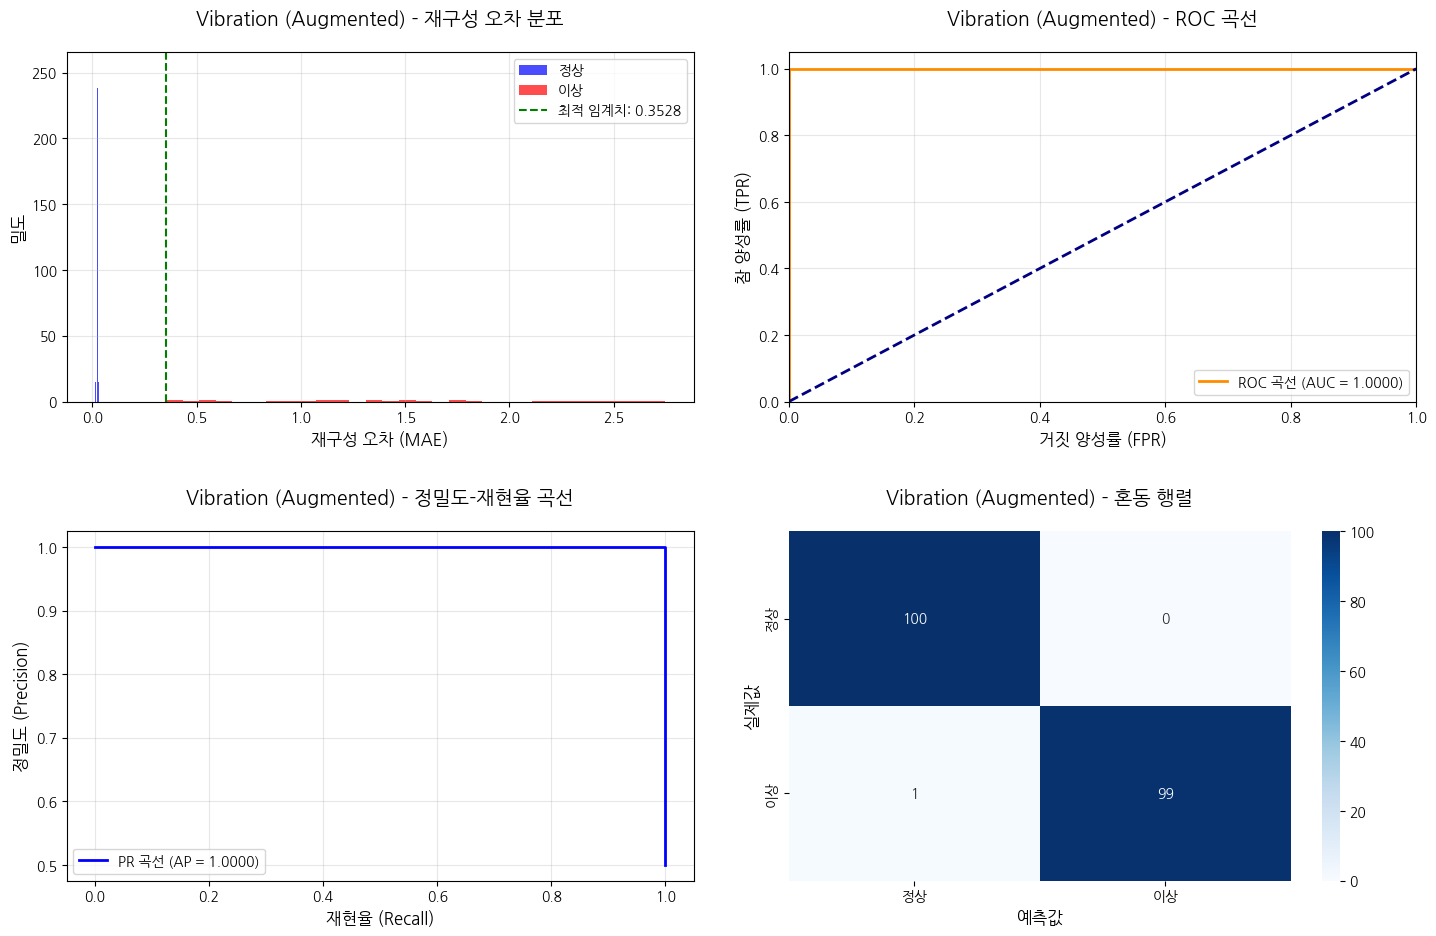


--- 기존 임계치 (0.068197) 비교 ---
기존 임계치 정확도: 1.0000
기존 임계치 F1-점수: 1.0000

=== Current (Augmented) 데이터 오토인코더 평가 ===
재구성 오차 통계:
  평균: 0.445431
  표준편차: 0.485802
  최소값: 0.005688
  최대값: 1.446418

클래스별 재구성 오차:
  정상 데이터 평균: 0.007633 ± 0.001006
  이상 데이터 평균: 0.883228 ± 0.297778

성능 지표:
  ROC AUC: 1.0000
  최적 임계치: 0.162985

분류 성능 (임계치: 0.162985):
              precision    recall  f1-score   support

          정상     0.9901    1.0000    0.9950       100
          이상     1.0000    0.9900    0.9950       100

    accuracy                         0.9950       200
   macro avg     0.9950    0.9950    0.9950       200
weighted avg     0.9950    0.9950    0.9950       200

한글 폰트 설정 완료: /usr/share/fonts/truetype/nanum/NanumGothic.ttf


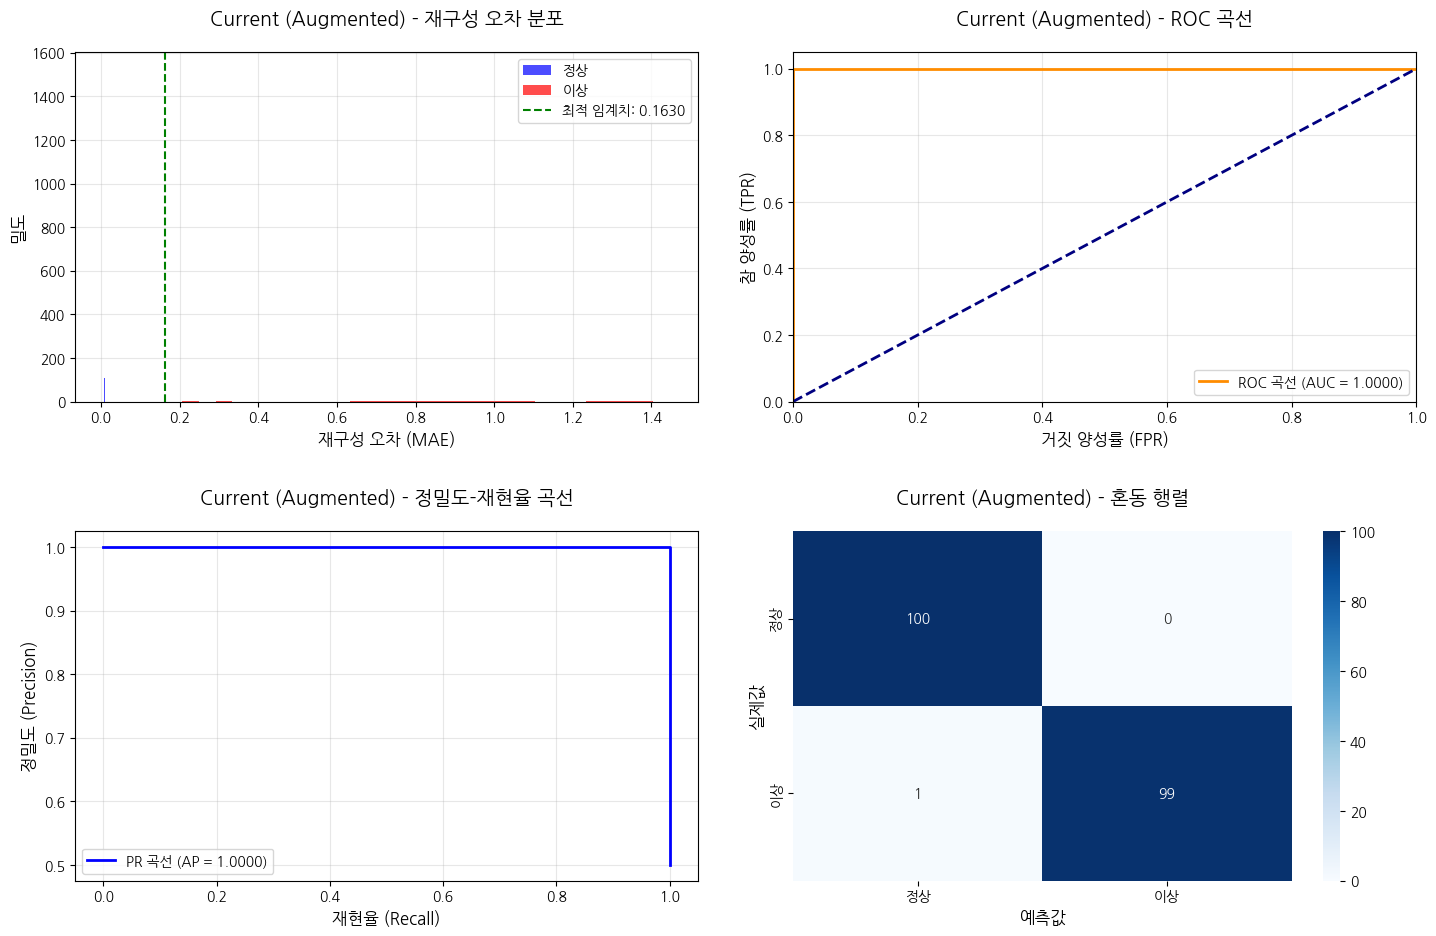


--- 기존 임계치 (0.170350) 비교 ---
기존 임계치 정확도: 0.9950
기존 임계치 F1-점수: 0.9950

PERFORMANCE COMPARISON

=== Vibration 데이터: 원본 vs 증강 데이터 성능 비교 ===
ROC AUC:
  원본 데이터: 1.0000
  증강 데이터: 1.0000
  차이: +0.0000

평균 정밀도:
  원본 데이터: 1.0000
  증강 데이터: 1.0000
  차이: +0.0000


=== Current 데이터: 원본 vs 증강 데이터 성능 비교 ===
ROC AUC:
  원본 데이터: 1.0000
  증강 데이터: 1.0000
  차이: +0.0000

평균 정밀도:
  원본 데이터: 1.0000
  증강 데이터: 1.0000
  차이: +0.0000


FINAL SUMMARY

Vibration Model:
  Original ROC AUC:   1.0000
  Augmented ROC AUC:  1.0000
  Improvement:        +0.0000

Current Model:
  Original ROC AUC:   1.0000
  Augmented ROC AUC:  1.0000
  Improvement:        +0.0000


In [51]:
# 전체 평가 시스템 실행 (데이터 증강 포함)
results = run_unified_evaluation_system(
    vib_model, cur_model,
    vib_test_dataset, cur_test_dataset,
    vib_threshold, cur_threshold,
    perform_augmentation=True,
    target_size_per_class=100
)